#### Imports

In [13]:
from pathlib import Path
from omegaconf import OmegaConf
import torch
import numpy as np
import wandb
from hydra import initialize, compose
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torch import nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import wandb
from datetime import datetime
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA

In [2]:
import sys
import os
from pathlib import Path

def get_project_root():
    if '__file__' not in globals():
        return Path(os.getcwd()).resolve()
    else:
        return Path(__file__).resolve().parent

project_root = get_project_root()
sys.path.insert(0, str(project_root))

print("Project root:", project_root)
print("Contenido:", os.listdir(project_root))

Project root: E:\IA\ProyectoAnomalias
Contenido: ['.git', '.gitignore', '.vscode', 'anomalias.ipynb', 'checkpoints', 'conf', 'Images', 'logs', 'Proyectos_Proyecto_II.pdf', 'src', 'trainer-project', 'train_model.py', '__pycache__']


### Se toman las 10 carpetas (cable, capsule, grid, hazelnut, leather, metal_nut, pill, screw, tile, transistor) y se separa su información de testing training y se juntan en un solo dataset, igualmente guardando las etiquetas y se setea el tamaño de cada imagen en 128x128

# Modelos entrenamiento

## Entrenamiento de Modelos ResNet para MVTec AD,
   ### Modelo A_1: Scratch | Modelo A_2: Distilled,
Este notebook entrena modelos con diferentes configuraciones usando Hydra + PyTorch Lightning + WandB"

In [3]:
import sys
sys.path.append('../')

import os
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
import hydra
from omegaconf import DictConfig, OmegaConf
import wandb

from src.data.mvtec_datamodule import MVTecDataModule
from src.models.resnet_scratch import ResNetScratchModule
from src.models.resnet_distilled import ResNetDistilledModule

print(f"PyTorch: {torch.__version__}")
print(f"Lightning: {pl.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch: 2.6.0+cu124
Lightning: 2.6.0
CUDA available: True
GPU: NVIDIA GeForce RTX 3060


#### Configuracion con hydra
Hydra permite cargar configuraciones de maneras modulares y hacer override desde el notebook

In [4]:
from hydra import compose, initialize
from hydra.core.global_hydra import GlobalHydra

GlobalHydra.instance().clear()

initialize(config_path="./conf", version_base="1.3")

cfg = compose(config_name="config")

print("\n=== CONFIGURACIÓN CARGADA ===")
print(OmegaConf.to_yaml(cfg))


=== CONFIGURACIÓN CARGADA ===
model:
  loss:
    name: cross_entropy
    type: classification
    label_smoothing: 0.0
    weight: null
  optimizer:
    name: adam
    learning_rate: 0.001
    weight_decay: 0.0001
    betas:
    - 0.9
    - 0.999
    eps: 1.0e-08
    amsgrad: false
    scheduler:
      name: cosine
      enabled: true
      T_max: 100
      eta_min: 1.0e-06
  name: resnet_scratch
  type: scratch
  latent_dim: 128
  dropout: 0.3
  use_batch_norm: true
  learning_rate: 0.001
  weight_decay: 0.0001
  batch_size: 32
  max_epochs: 100
trainer:
  trainer: null
  accelerator: auto
  devices: 1
  precision: 32
  max_epochs: 100
logger:
  name: wandb
  project: mvtec-anomaly-detection
  entity: null
  save_dir: ./logs
  log_model: true
  log_gradients: false
  log_graph: false
  offline: false
  tags: []
  notes: null
loss:
  name: cross_entropy
  type: classification
  label_smoothing: 0.0
  weight: null
optimizer:
  name: adam
  learning_rate: 0.001
  weight_decay: 0.0001
  

### Preparar DataModule

In [5]:
pl.seed_everything(cfg.seed, workers=True)

datamodule = MVTecDataModule(
    data_dir=cfg.data.data_dir,
    class_names=cfg.class_names,
    batch_size=cfg.data.batch_size,
    num_workers=cfg.data.num_workers,
    pin_memory=cfg.data.pin_memory
)

datamodule.setup()

print("\n=== DATASET STATISTICS ===")
stats = datamodule.get_num_samples()
print(f"Train samples:      {stats['train']}")
print(f"Validation samples: {stats['val']}")
print(f"Test samples:       {stats['test']}")
print(f"\nBatch size: {cfg.data.batch_size}")
print(f"Train batches per epoch: {stats['train'] // cfg.data.batch_size}")


Seed set to 42



=== DATASET STATISTICS ===
Train samples:      2072
Validation samples: 521
Test samples:       1253

Batch size: 32
Train batches per epoch: 64


### Funcion de entrenamiento

#### Entrenamiento Modelos ResNet - MVTec Anomaly Detection


In [7]:

import sys
import os
from pathlib import Path
import pytorch_lightning as pl
import numpy as np


def get_project_root():
    
    return Path(os.getcwd()).resolve()

project_root = get_project_root()


src_path = project_root / "src"
if src_path.exists():
    sys.path.insert(0, str(src_path))
else:
    sys.path.insert(0, str(project_root))

print("Project root:", project_root)
print("sys.path[0]:", sys.path[0])

# Import train_model (try both possibilities) and use the src package for datamodule

from train_model import train_model, load_trained_model

Project root: E:\IA\ProyectoAnomalias
sys.path[0]: E:\IA\ProyectoAnomalias\src


####  Cargar Configuración Base

In [8]:
from hydra import compose, initialize_config_dir
from hydra.core.global_hydra import GlobalHydra
from omegaconf import OmegaConf

try:
    GlobalHydra.instance().clear()
except Exception:
    # safe fallback if GlobalHydra not initialized
    pass
# Inicializar Hydra con path absoluto
config_dir = str(project_root / "conf")
initialize_config_dir(config_dir=config_dir, version_base=None)

# Cargar config base
cfg = compose(config_name="config")


print("="*80)
print("CONFIGURACIÓN BASE")
print("="*80)
print(OmegaConf.to_yaml(cfg))

CONFIGURACIÓN BASE
model:
  loss:
    name: cross_entropy
    type: classification
    label_smoothing: 0.0
    weight: null
  optimizer:
    name: adam
    learning_rate: 0.001
    weight_decay: 0.0001
    betas:
    - 0.9
    - 0.999
    eps: 1.0e-08
    amsgrad: false
    scheduler:
      name: cosine
      enabled: true
      T_max: 100
      eta_min: 1.0e-06
  name: resnet_scratch
  type: scratch
  latent_dim: 128
  dropout: 0.3
  use_batch_norm: true
  learning_rate: 0.001
  weight_decay: 0.0001
  batch_size: 32
  max_epochs: 100
trainer:
  trainer: null
  accelerator: auto
  devices: 1
  precision: 32
  max_epochs: 100
logger:
  name: wandb
  project: mvtec-anomaly-detection
  entity: null
  save_dir: ./logs
  log_model: true
  log_gradients: false
  log_graph: false
  offline: false
  tags: []
  notes: null
loss:
  name: cross_entropy
  type: classification
  label_smoothing: 0.0
  weight: null
optimizer:
  name: adam
  learning_rate: 0.001
  weight_decay: 0.0001
  betas:
  - 0

### Carga de Checkpoints

In [9]:
def get_or_train_model(cfg, datamodule, model_type, force_retrain=True):
    """
    Busca si ya existe un checkpoint entrenado.
    Si existe: Lo carga y devuelve el modelo.
    Si NO existe (o force_retrain=True): Entrena el modelo usando train_model.
    """
    # 1. Determinar el nombre del run y el directorio
    if cfg.experiment.run_name:
        run_name = cfg.experiment.run_name
    else:
        # Replicar lógica de nombre por defecto si es necesario, 
        # pero idealmente siempre define run_name en hydra overrides
        run_name = f"{cfg.model.name}_z{cfg.model.latent_dim}"
        
    checkpoint_dir = Path(f'./checkpoints/{run_name}')
    
    # 2. Buscar si existe un checkpoint 'best' o 'last'
    # Buscamos cualquier archivo que empiece con 'best' o sea 'last.ckpt'
    existing_ckpts = list(checkpoint_dir.glob('*.ckpt'))
    
    # Filtrar para preferir el 'best'
    best_ckpt = None
    for ckpt in existing_ckpts:
        if "best" in ckpt.name:
            best_ckpt = ckpt
            break
    if best_ckpt is None and existing_ckpts:
        best_ckpt = existing_ckpts[0] # Usar cualquiera si no hay best explícito
        
    # 3. Lógica de Decisión
    if best_ckpt and not force_retrain:
        print(f"\nModelo encontrado en: {best_ckpt}")
        print("   -> Cargando pesos guardados (saltando entrenamiento)...")
        
        # Cargar modelo usando tu función existente en train_model.py
        model = load_trained_model(str(best_ckpt), model_type=model_type)
        
        # Crear un trainer 'dummy' solo para poder ejecutar .test() o .predict() si quisieras
        # No se usa para entrenar, así que max_epochs=0 evita accidentes
        trainer = pl.Trainer(accelerator='auto', devices=1, logger=False)
        
        return trainer, model
        
    else:
        if force_retrain and best_ckpt:
            print(f"\nForzando re-entrenamiento (Sobreescribiendo {run_name})...")
        else:
            print(f"\nNo se encontró checkpoint previo. Iniciando entrenamiento: {run_name}...")
            
        # Llamar a tu función original de entrenamiento
        return train_model(cfg=cfg, datamodule=datamodule, model_type=model_type)

# Experiments: Autoencoder Unet

### EXPERIMENTO 1: U-Net con MSE Loss

In [10]:
cfg_unet_mse = compose(
    config_name="config",
    overrides=[
        "model=unet_autoencoder",
        "loss=mse",
        "experiment.run_name=unet_z128_mse",
        "callbacks.early_stopping.patience=3",
        "callbacks.early_stopping.min_delta=0.0"
    ]
)

trainer_u1, model_u1 = get_or_train_model(
    cfg=cfg_unet_mse,
    datamodule=datamodule,
    model_type="autoencoder"
)


Forzando re-entrenamiento (Sobreescribiendo unet_z128_mse)...


wandb: WARNING The anonymous setting has no effect and will be removed in a future version.



 Run Name: unet_z128_mse


wandb: Currently logged in as: fdbrenes17 (fdbrenes17-tec-costa-rica) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision



=== INICIANDO ENTRENAMIENTO: unet_z128_mse ===


e:\python\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:881: Checkpoint directory E:\IA\ProyectoAnomalias\checkpoints\unet_z128_mse exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode  | FLOPs
-----------------------------------------------------------------
0 | enc_blocks  | ModuleList       | 1.2 M  | train | 0    
1 | downsamples | ModuleList       | 348 K  | train | 0    
2 | bottleneck  | UNetEncoderBlock | 3.5 M  | train | 0    
3 | dec_blocks  | ModuleList       | 3.0 M  | train | 0    
4 | final_conv  | Conv2d           | 99     | train | 0    
5 | activation  | Sigmoid          | 0      | train | 0    
6 | criterion   | MSELoss          | 0      | train | 0    
-----------------------------------------------------------------
8.1 M     Trainable params
0         Non-trainable params
8.1 M     Total params
32.435    Total estimated model params size (MB)
68        Modules in train mode
0     

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 65/65 [00:10<00:00,  6.19it/s, v_num=kn8x, val/loss=0.00376, train/loss=0.020]

Metric val/loss improved. New best score: 0.004
Epoch 0, global step 65: 'val/loss' reached 0.00376 (best 0.00376), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=00-val/loss=0.0038-v1.ckpt' as top 3


Epoch 1: 100%|██████████| 65/65 [00:10<00:00,  6.50it/s, v_num=kn8x, val/loss=0.00142, train/loss=0.00225]

Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.001
Epoch 1, global step 130: 'val/loss' reached 0.00142 (best 0.00142), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=01-val/loss=0.0014.ckpt' as top 3


Epoch 2: 100%|██████████| 65/65 [00:10<00:00,  6.40it/s, v_num=kn8x, val/loss=0.00113, train/loss=0.00135]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
Epoch 2, global step 195: 'val/loss' reached 0.00113 (best 0.00113), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=02-val/loss=0.0011.ckpt' as top 3


Epoch 3: 100%|██████████| 65/65 [00:10<00:00,  6.40it/s, v_num=kn8x, val/loss=0.00111, train/loss=0.00111]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
Epoch 3, global step 260: 'val/loss' reached 0.00111 (best 0.00111), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=03-val/loss=0.0011.ckpt' as top 3


Epoch 4: 100%|██████████| 65/65 [00:10<00:00,  6.25it/s, v_num=kn8x, val/loss=0.000859, train/loss=0.000986]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
Epoch 4, global step 325: 'val/loss' reached 0.00086 (best 0.00086), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=04-val/loss=0.0009.ckpt' as top 3


Epoch 5: 100%|██████████| 65/65 [00:10<00:00,  6.34it/s, v_num=kn8x, val/loss=0.000877, train/loss=0.000871]

Epoch 5, global step 390: 'val/loss' reached 0.00088 (best 0.00086), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=05-val/loss=0.0009.ckpt' as top 3


Epoch 6: 100%|██████████| 65/65 [00:10<00:00,  6.43it/s, v_num=kn8x, val/loss=0.000661, train/loss=0.000789]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
Epoch 6, global step 455: 'val/loss' reached 0.00066 (best 0.00066), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=06-val/loss=0.0007.ckpt' as top 3


Epoch 7: 100%|██████████| 65/65 [00:10<00:00,  6.35it/s, v_num=kn8x, val/loss=0.00059, train/loss=0.000668] 

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
Epoch 7, global step 520: 'val/loss' reached 0.00059 (best 0.00059), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=07-val/loss=0.0006.ckpt' as top 3


Epoch 8: 100%|██████████| 65/65 [00:10<00:00,  6.35it/s, v_num=kn8x, val/loss=0.000549, train/loss=0.000624]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
Epoch 8, global step 585: 'val/loss' reached 0.00055 (best 0.00055), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=08-val/loss=0.0005.ckpt' as top 3


Epoch 9: 100%|██████████| 65/65 [00:09<00:00,  6.52it/s, v_num=kn8x, val/loss=0.00053, train/loss=0.000603] 

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
Epoch 9, global step 650: 'val/loss' reached 0.00053 (best 0.00053), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=09-val/loss=0.0005.ckpt' as top 3


Epoch 10: 100%|██████████| 65/65 [00:10<00:00,  6.48it/s, v_num=kn8x, val/loss=0.0011, train/loss=0.000618] 

Epoch 10, global step 715: 'val/loss' was not in top 3


Epoch 11: 100%|██████████| 65/65 [00:10<00:00,  6.41it/s, v_num=kn8x, val/loss=0.000512, train/loss=0.000573]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
Epoch 11, global step 780: 'val/loss' reached 0.00051 (best 0.00051), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=11-val/loss=0.0005.ckpt' as top 3


Epoch 12: 100%|██████████| 65/65 [00:10<00:00,  6.37it/s, v_num=kn8x, val/loss=0.000468, train/loss=0.000502]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 12, global step 845: 'val/loss' reached 0.00047 (best 0.00047), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=12-val/loss=0.0005.ckpt' as top 3


Epoch 13: 100%|██████████| 65/65 [00:10<00:00,  6.41it/s, v_num=kn8x, val/loss=0.000478, train/loss=0.000475]

Epoch 13, global step 910: 'val/loss' reached 0.00048 (best 0.00047), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=13-val/loss=0.0005.ckpt' as top 3


Epoch 14: 100%|██████████| 65/65 [00:10<00:00,  6.42it/s, v_num=kn8x, val/loss=0.000443, train/loss=0.000523]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 14, global step 975: 'val/loss' reached 0.00044 (best 0.00044), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=14-val/loss=0.0004.ckpt' as top 3


Epoch 15: 100%|██████████| 65/65 [00:10<00:00,  6.41it/s, v_num=kn8x, val/loss=0.000397, train/loss=0.000442]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 15, global step 1040: 'val/loss' reached 0.00040 (best 0.00040), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=15-val/loss=0.0004.ckpt' as top 3


Epoch 16: 100%|██████████| 65/65 [00:10<00:00,  6.41it/s, v_num=kn8x, val/loss=0.000466, train/loss=0.000442]

Epoch 16, global step 1105: 'val/loss' reached 0.00047 (best 0.00040), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=16-val/loss=0.0005.ckpt' as top 3


Epoch 17: 100%|██████████| 65/65 [00:10<00:00,  6.45it/s, v_num=kn8x, val/loss=0.00039, train/loss=0.000443] 

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 17, global step 1170: 'val/loss' reached 0.00039 (best 0.00039), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=17-val/loss=0.0004.ckpt' as top 3


Epoch 18: 100%|██████████| 65/65 [00:10<00:00,  6.33it/s, v_num=kn8x, val/loss=0.000371, train/loss=0.00039] 

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 18, global step 1235: 'val/loss' reached 0.00037 (best 0.00037), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=18-val/loss=0.0004.ckpt' as top 3


Epoch 19: 100%|██████████| 65/65 [00:10<00:00,  6.44it/s, v_num=kn8x, val/loss=0.000346, train/loss=0.000421]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 19, global step 1300: 'val/loss' reached 0.00035 (best 0.00035), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=19-val/loss=0.0003.ckpt' as top 3


Epoch 20: 100%|██████████| 65/65 [00:10<00:00,  6.32it/s, v_num=kn8x, val/loss=0.000375, train/loss=0.000416]

Epoch 20, global step 1365: 'val/loss' reached 0.00038 (best 0.00035), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=20-val/loss=0.0004.ckpt' as top 3


Epoch 21: 100%|██████████| 65/65 [00:10<00:00,  6.39it/s, v_num=kn8x, val/loss=0.000353, train/loss=0.00039] 

Epoch 21, global step 1430: 'val/loss' reached 0.00035 (best 0.00035), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=21-val/loss=0.0004.ckpt' as top 3


Epoch 22: 100%|██████████| 65/65 [00:10<00:00,  6.33it/s, v_num=kn8x, val/loss=0.000327, train/loss=0.000371]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 22, global step 1495: 'val/loss' reached 0.00033 (best 0.00033), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=22-val/loss=0.0003.ckpt' as top 3


Epoch 23: 100%|██████████| 65/65 [00:10<00:00,  6.39it/s, v_num=kn8x, val/loss=0.000408, train/loss=0.000381]

Epoch 23, global step 1560: 'val/loss' was not in top 3


Epoch 24: 100%|██████████| 65/65 [00:10<00:00,  6.09it/s, v_num=kn8x, val/loss=0.000407, train/loss=0.0004]  

Epoch 24, global step 1625: 'val/loss' was not in top 3


Epoch 25: 100%|██████████| 65/65 [00:10<00:00,  6.26it/s, v_num=kn8x, val/loss=0.0003, train/loss=0.000365]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 25, global step 1690: 'val/loss' reached 0.00030 (best 0.00030), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=25-val/loss=0.0003.ckpt' as top 3


Epoch 26: 100%|██████████| 65/65 [00:10<00:00,  6.18it/s, v_num=kn8x, val/loss=0.000451, train/loss=0.00034] 

Epoch 26, global step 1755: 'val/loss' was not in top 3


Epoch 27: 100%|██████████| 65/65 [00:10<00:00,  6.35it/s, v_num=kn8x, val/loss=0.000316, train/loss=0.000353]

Epoch 27, global step 1820: 'val/loss' reached 0.00032 (best 0.00030), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=27-val/loss=0.0003.ckpt' as top 3


Epoch 28: 100%|██████████| 65/65 [00:10<00:00,  6.39it/s, v_num=kn8x, val/loss=0.000289, train/loss=0.00035] 

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 28, global step 1885: 'val/loss' reached 0.00029 (best 0.00029), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=28-val/loss=0.0003.ckpt' as top 3


Epoch 29: 100%|██████████| 65/65 [00:10<00:00,  6.34it/s, v_num=kn8x, val/loss=0.000429, train/loss=0.000331]

Epoch 29, global step 1950: 'val/loss' was not in top 3


Epoch 30: 100%|██████████| 65/65 [00:10<00:00,  6.37it/s, v_num=kn8x, val/loss=0.000281, train/loss=0.000326]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 30, global step 2015: 'val/loss' reached 0.00028 (best 0.00028), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=30-val/loss=0.0003.ckpt' as top 3


Epoch 31: 100%|██████████| 65/65 [00:10<00:00,  6.46it/s, v_num=kn8x, val/loss=0.000286, train/loss=0.000331]

Epoch 31, global step 2080: 'val/loss' reached 0.00029 (best 0.00028), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=31-val/loss=0.0003.ckpt' as top 3


Epoch 32: 100%|██████████| 65/65 [00:10<00:00,  6.38it/s, v_num=kn8x, val/loss=0.000276, train/loss=0.000311]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 32, global step 2145: 'val/loss' reached 0.00028 (best 0.00028), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=32-val/loss=0.0003.ckpt' as top 3


Epoch 33: 100%|██████████| 65/65 [00:10<00:00,  6.46it/s, v_num=kn8x, val/loss=0.000339, train/loss=0.000368]

Epoch 33, global step 2210: 'val/loss' was not in top 3


Epoch 34: 100%|██████████| 65/65 [00:10<00:00,  6.33it/s, v_num=kn8x, val/loss=0.000271, train/loss=0.000311]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 34, global step 2275: 'val/loss' reached 0.00027 (best 0.00027), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=34-val/loss=0.0003.ckpt' as top 3


Epoch 35: 100%|██████████| 65/65 [00:10<00:00,  6.38it/s, v_num=kn8x, val/loss=0.000411, train/loss=0.000357]

Epoch 35, global step 2340: 'val/loss' was not in top 3


Epoch 36: 100%|██████████| 65/65 [00:09<00:00,  6.56it/s, v_num=kn8x, val/loss=0.000268, train/loss=0.000338]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 36, global step 2405: 'val/loss' reached 0.00027 (best 0.00027), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=36-val/loss=0.0003.ckpt' as top 3


Epoch 37: 100%|██████████| 65/65 [00:10<00:00,  6.40it/s, v_num=kn8x, val/loss=0.000332, train/loss=0.000297]

Epoch 37, global step 2470: 'val/loss' was not in top 3


Epoch 38: 100%|██████████| 65/65 [00:10<00:00,  6.44it/s, v_num=kn8x, val/loss=0.000266, train/loss=0.000308]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 38, global step 2535: 'val/loss' reached 0.00027 (best 0.00027), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=38-val/loss=0.0003.ckpt' as top 3


Epoch 39: 100%|██████████| 65/65 [00:10<00:00,  6.49it/s, v_num=kn8x, val/loss=0.000268, train/loss=0.000322]

Epoch 39, global step 2600: 'val/loss' reached 0.00027 (best 0.00027), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=39-val/loss=0.0003.ckpt' as top 3


Epoch 40: 100%|██████████| 65/65 [00:10<00:00,  6.33it/s, v_num=kn8x, val/loss=0.00027, train/loss=0.000283] 

Epoch 40, global step 2665: 'val/loss' was not in top 3


Epoch 41: 100%|██████████| 65/65 [00:10<00:00,  6.32it/s, v_num=kn8x, val/loss=0.000259, train/loss=0.000282]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 41, global step 2730: 'val/loss' reached 0.00026 (best 0.00026), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=41-val/loss=0.0003-v3.ckpt' as top 3


Epoch 42: 100%|██████████| 65/65 [00:10<00:00,  6.42it/s, v_num=kn8x, val/loss=0.000257, train/loss=0.000295]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 42, global step 2795: 'val/loss' reached 0.00026 (best 0.00026), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=42-val/loss=0.0003-v3.ckpt' as top 3


Epoch 43: 100%|██████████| 65/65 [00:10<00:00,  6.19it/s, v_num=kn8x, val/loss=0.000287, train/loss=0.000287]

Epoch 43, global step 2860: 'val/loss' was not in top 3


Epoch 44: 100%|██████████| 65/65 [00:10<00:00,  6.44it/s, v_num=kn8x, val/loss=0.000258, train/loss=0.000286]

Epoch 44, global step 2925: 'val/loss' reached 0.00026 (best 0.00026), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=44-val/loss=0.0003-v3.ckpt' as top 3


Epoch 45: 100%|██████████| 65/65 [00:10<00:00,  6.41it/s, v_num=kn8x, val/loss=0.000343, train/loss=0.000285]

Monitored metric val/loss did not improve in the last 3 records. Best score: 0.000. Signaling Trainer to stop.
Epoch 45, global step 2990: 'val/loss' was not in top 3


Epoch 45: 100%|██████████| 65/65 [00:10<00:00,  6.41it/s, v_num=kn8x, val/loss=0.000343, train/loss=0.000285]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



=== ENTRENAMIENTO COMPLETADO ===

=== EJECUTANDO TEST & T-SNE ===
Testing DataLoader 0: 100%|██████████| 40/40 [00:02<00:00, 19.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/loss         0.00037115378654561937
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
lr-Adam,██████████▇▇▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▁▁
test/loss,▁
train/loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇████
val/loss,█▃▃▃▂▂▂▂▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,46
lr-Adam,0.00058
test/loss,0.00037
train/loss,0.00028
trainer/global_step,2990


### EXPERIMENTO 2: U-Net con L1 Loss

In [11]:
cfg_unet_l1 = compose(
    config_name="config",
    overrides=[
        "model=unet_autoencoder",
        "loss=l1",
        "experiment.run_name=unet_z128_l1"
    ]
)

trainer_u2, model_u2 = get_or_train_model(
    cfg=cfg_unet_l1,
    datamodule=datamodule,
    model_type="autoencoder"
)


No se encontró checkpoint previo. Iniciando entrenamiento: unet_z128_l1...

 Run Name: unet_z128_l1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



=== INICIANDO ENTRENAMIENTO: unet_z128_l1 ===


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode  | FLOPs
-----------------------------------------------------------------
0 | enc_blocks  | ModuleList       | 1.2 M  | train | 0    
1 | downsamples | ModuleList       | 348 K  | train | 0    
2 | bottleneck  | UNetEncoderBlock | 3.5 M  | train | 0    
3 | dec_blocks  | ModuleList       | 3.0 M  | train | 0    
4 | final_conv  | Conv2d           | 99     | train | 0    
5 | activation  | Sigmoid          | 0      | train | 0    
6 | criterion   | L1Loss           | 0      | train | 0    
-----------------------------------------------------------------
8.1 M     Trainable params
0         Non-trainable params
8.1 M     Total params
32.435    Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 10.76it/s]

e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 65/65 [00:10<00:00,  6.14it/s, v_num=na1c, val/loss=0.044, train/loss=0.0906]

Metric val/loss improved. New best score: 0.044
Epoch 0, global step 65: 'val/loss' reached 0.04403 (best 0.04403), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_l1\\best-epoch=00-val/loss=0.0440.ckpt' as top 3


Epoch 1: 100%|██████████| 65/65 [00:10<00:00,  6.36it/s, v_num=na1c, val/loss=0.0261, train/loss=0.039] 

Metric val/loss improved by 0.018 >= min_delta = 0.0. New best score: 0.026
Epoch 1, global step 130: 'val/loss' reached 0.02610 (best 0.02610), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_l1\\best-epoch=01-val/loss=0.0261.ckpt' as top 3


Epoch 2: 100%|██████████| 65/65 [00:10<00:00,  6.31it/s, v_num=na1c, val/loss=0.0221, train/loss=0.0263]

Metric val/loss improved by 0.004 >= min_delta = 0.0. New best score: 0.022
Epoch 2, global step 195: 'val/loss' reached 0.02211 (best 0.02211), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_l1\\best-epoch=02-val/loss=0.0221.ckpt' as top 3


Epoch 3: 100%|██████████| 65/65 [00:10<00:00,  6.48it/s, v_num=na1c, val/loss=0.0202, train/loss=0.0236]

Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.020
Epoch 3, global step 260: 'val/loss' reached 0.02020 (best 0.02020), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_l1\\best-epoch=03-val/loss=0.0202.ckpt' as top 3


Epoch 4: 100%|██████████| 65/65 [00:10<00:00,  6.32it/s, v_num=na1c, val/loss=0.0277, train/loss=0.0231]

Epoch 4, global step 325: 'val/loss' was not in top 3


Epoch 5: 100%|██████████| 65/65 [00:10<00:00,  6.42it/s, v_num=na1c, val/loss=0.0216, train/loss=0.0227]

Epoch 5, global step 390: 'val/loss' reached 0.02164 (best 0.02020), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_l1\\best-epoch=05-val/loss=0.0216.ckpt' as top 3


Epoch 6: 100%|██████████| 65/65 [00:10<00:00,  6.41it/s, v_num=na1c, val/loss=0.0236, train/loss=0.0216]

Monitored metric val/loss did not improve in the last 3 records. Best score: 0.020. Signaling Trainer to stop.
Epoch 6, global step 455: 'val/loss' was not in top 3


Epoch 6: 100%|██████████| 65/65 [00:10<00:00,  6.41it/s, v_num=na1c, val/loss=0.0236, train/loss=0.0216]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



=== ENTRENAMIENTO COMPLETADO ===

=== EJECUTANDO TEST & T-SNE ===
Testing DataLoader 0: 100%|██████████| 40/40 [00:02<00:00, 19.78it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/loss          0.024568621069192886
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇█
lr-Adam,██▇▆▅▃▁
test/loss,▁
train/loss,█▃▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
val/loss,█▃▂▁▃▁▂
epoch,7
lr-Adam,0.00099
test/loss,0.02457
train/loss,0.02163
trainer/global_step,455


### EXPERIMENTO 3: U-Net con SSIM Loss

In [12]:
cfg_unet_ssim = compose(
    config_name="config",
    overrides=[
        "model=unet_autoencoder",
        "loss=ssim",
        "experiment.run_name=unet_z128_ssim"
    ]
)

trainer_u3, model_u3 = get_or_train_model(
    cfg=cfg_unet_ssim,
    datamodule=datamodule,
    model_type="autoencoder"
)


No se encontró checkpoint previo. Iniciando entrenamiento: unet_z128_ssim...

 Run Name: unet_z128_ssim


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



=== INICIANDO ENTRENAMIENTO: unet_z128_ssim ===


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode  | FLOPs
-----------------------------------------------------------------
0 | enc_blocks  | ModuleList       | 1.2 M  | train | 0    
1 | downsamples | ModuleList       | 348 K  | train | 0    
2 | bottleneck  | UNetEncoderBlock | 3.5 M  | train | 0    
3 | dec_blocks  | ModuleList       | 3.0 M  | train | 0    
4 | final_conv  | Conv2d           | 99     | train | 0    
5 | activation  | Sigmoid          | 0      | train | 0    
6 | criterion   | SSIMLoss         | 0      | train | 0    
-----------------------------------------------------------------
8.1 M     Trainable params
0         Non-trainable params
8.1 M     Total params
32.435    Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 65/65 [00:11<00:00,  5.89it/s, v_num=b68l, val/loss=0.0895, train/loss=0.247]

Metric val/loss improved. New best score: 0.090
Epoch 0, global step 65: 'val/loss' reached 0.08954 (best 0.08954), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=00-val/loss=0.0895.ckpt' as top 3


Epoch 1: 100%|██████████| 65/65 [00:10<00:00,  6.07it/s, v_num=b68l, val/loss=0.0378, train/loss=0.0631]

Metric val/loss improved by 0.052 >= min_delta = 0.0. New best score: 0.038
Epoch 1, global step 130: 'val/loss' reached 0.03775 (best 0.03775), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=01-val/loss=0.0378.ckpt' as top 3


Epoch 2: 100%|██████████| 65/65 [00:10<00:00,  6.00it/s, v_num=b68l, val/loss=0.0152, train/loss=0.0231]

Metric val/loss improved by 0.023 >= min_delta = 0.0. New best score: 0.015
Epoch 2, global step 195: 'val/loss' reached 0.01521 (best 0.01521), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=02-val/loss=0.0152.ckpt' as top 3


Epoch 3: 100%|██████████| 65/65 [00:10<00:00,  6.00it/s, v_num=b68l, val/loss=0.0109, train/loss=0.014] 

Metric val/loss improved by 0.004 >= min_delta = 0.0. New best score: 0.011
Epoch 3, global step 260: 'val/loss' reached 0.01091 (best 0.01091), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=03-val/loss=0.0109.ckpt' as top 3


Epoch 4: 100%|██████████| 65/65 [00:10<00:00,  6.05it/s, v_num=b68l, val/loss=0.00835, train/loss=0.0105]

Metric val/loss improved by 0.003 >= min_delta = 0.0. New best score: 0.008
Epoch 4, global step 325: 'val/loss' reached 0.00835 (best 0.00835), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=04-val/loss=0.0084.ckpt' as top 3


Epoch 5: 100%|██████████| 65/65 [00:10<00:00,  6.02it/s, v_num=b68l, val/loss=0.0135, train/loss=0.00894]

Epoch 5, global step 390: 'val/loss' reached 0.01351 (best 0.00835), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=05-val/loss=0.0135.ckpt' as top 3


Epoch 6: 100%|██████████| 65/65 [00:10<00:00,  6.00it/s, v_num=b68l, val/loss=0.00635, train/loss=0.0086] 

Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.006
Epoch 6, global step 455: 'val/loss' reached 0.00635 (best 0.00635), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=06-val/loss=0.0064.ckpt' as top 3


Epoch 7: 100%|██████████| 65/65 [00:11<00:00,  5.90it/s, v_num=b68l, val/loss=0.00604, train/loss=0.00706]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 7, global step 520: 'val/loss' reached 0.00604 (best 0.00604), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=07-val/loss=0.0060.ckpt' as top 3


Epoch 8: 100%|██████████| 65/65 [00:10<00:00,  6.01it/s, v_num=b68l, val/loss=0.00582, train/loss=0.00659]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 8, global step 585: 'val/loss' reached 0.00582 (best 0.00582), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=08-val/loss=0.0058.ckpt' as top 3


Epoch 9: 100%|██████████| 65/65 [00:11<00:00,  5.81it/s, v_num=b68l, val/loss=0.00529, train/loss=0.00606]

Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.005
Epoch 9, global step 650: 'val/loss' reached 0.00529 (best 0.00529), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=09-val/loss=0.0053.ckpt' as top 3


Epoch 10: 100%|██████████| 65/65 [00:10<00:00,  6.09it/s, v_num=b68l, val/loss=0.00507, train/loss=0.00606]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005
Epoch 10, global step 715: 'val/loss' reached 0.00507 (best 0.00507), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=10-val/loss=0.0051.ckpt' as top 3


Epoch 11: 100%|██████████| 65/65 [00:10<00:00,  5.96it/s, v_num=b68l, val/loss=0.00527, train/loss=0.00575]

Epoch 11, global step 780: 'val/loss' reached 0.00527 (best 0.00507), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=11-val/loss=0.0053.ckpt' as top 3


Epoch 12: 100%|██████████| 65/65 [00:10<00:00,  5.99it/s, v_num=b68l, val/loss=0.00472, train/loss=0.00577]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005
Epoch 12, global step 845: 'val/loss' reached 0.00472 (best 0.00472), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=12-val/loss=0.0047.ckpt' as top 3


Epoch 13: 100%|██████████| 65/65 [00:10<00:00,  6.03it/s, v_num=b68l, val/loss=0.00511, train/loss=0.00576]

Epoch 13, global step 910: 'val/loss' reached 0.00511 (best 0.00472), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=13-val/loss=0.0051.ckpt' as top 3


Epoch 14: 100%|██████████| 65/65 [00:10<00:00,  6.05it/s, v_num=b68l, val/loss=0.0042, train/loss=0.00548] 

Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.004
Epoch 14, global step 975: 'val/loss' reached 0.00420 (best 0.00420), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=14-val/loss=0.0042.ckpt' as top 3


Epoch 15: 100%|██████████| 65/65 [00:10<00:00,  6.01it/s, v_num=b68l, val/loss=0.00425, train/loss=0.00495]

Epoch 15, global step 1040: 'val/loss' reached 0.00425 (best 0.00420), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=15-val/loss=0.0043.ckpt' as top 3


Epoch 16: 100%|██████████| 65/65 [00:10<00:00,  5.95it/s, v_num=b68l, val/loss=0.00407, train/loss=0.00504]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004
Epoch 16, global step 1105: 'val/loss' reached 0.00407 (best 0.00407), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=16-val/loss=0.0041.ckpt' as top 3


Epoch 17: 100%|██████████| 65/65 [00:10<00:00,  6.00it/s, v_num=b68l, val/loss=0.00397, train/loss=0.00497]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004
Epoch 17, global step 1170: 'val/loss' reached 0.00397 (best 0.00397), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=17-val/loss=0.0040.ckpt' as top 3


Epoch 18: 100%|██████████| 65/65 [00:11<00:00,  5.88it/s, v_num=b68l, val/loss=0.00382, train/loss=0.00458]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004
Epoch 18, global step 1235: 'val/loss' reached 0.00382 (best 0.00382), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=18-val/loss=0.0038.ckpt' as top 3


Epoch 19: 100%|██████████| 65/65 [00:10<00:00,  5.96it/s, v_num=b68l, val/loss=0.00377, train/loss=0.00447]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004
Epoch 19, global step 1300: 'val/loss' reached 0.00377 (best 0.00377), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=19-val/loss=0.0038.ckpt' as top 3


Epoch 20: 100%|██████████| 65/65 [00:10<00:00,  6.12it/s, v_num=b68l, val/loss=0.00375, train/loss=0.00442]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004
Epoch 20, global step 1365: 'val/loss' reached 0.00375 (best 0.00375), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=20-val/loss=0.0038.ckpt' as top 3


Epoch 21: 100%|██████████| 65/65 [00:10<00:00,  6.01it/s, v_num=b68l, val/loss=0.00346, train/loss=0.00516]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003
Epoch 21, global step 1430: 'val/loss' reached 0.00346 (best 0.00346), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=21-val/loss=0.0035.ckpt' as top 3


Epoch 22: 100%|██████████| 65/65 [00:10<00:00,  5.99it/s, v_num=b68l, val/loss=0.00336, train/loss=0.00408]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003
Epoch 22, global step 1495: 'val/loss' reached 0.00336 (best 0.00336), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=22-val/loss=0.0034.ckpt' as top 3


Epoch 23: 100%|██████████| 65/65 [00:10<00:00,  6.14it/s, v_num=b68l, val/loss=0.0034, train/loss=0.00391] 

Epoch 23, global step 1560: 'val/loss' reached 0.00340 (best 0.00336), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=23-val/loss=0.0034.ckpt' as top 3


Epoch 24: 100%|██████████| 65/65 [00:10<00:00,  5.99it/s, v_num=b68l, val/loss=0.00334, train/loss=0.00411]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003
Epoch 24, global step 1625: 'val/loss' reached 0.00334 (best 0.00334), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=24-val/loss=0.0033.ckpt' as top 3


Epoch 25: 100%|██████████| 65/65 [00:10<00:00,  6.11it/s, v_num=b68l, val/loss=0.00317, train/loss=0.00401]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003
Epoch 25, global step 1690: 'val/loss' reached 0.00317 (best 0.00317), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=25-val/loss=0.0032.ckpt' as top 3


Epoch 26: 100%|██████████| 65/65 [00:10<00:00,  5.93it/s, v_num=b68l, val/loss=0.00297, train/loss=0.00365]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003
Epoch 26, global step 1755: 'val/loss' reached 0.00297 (best 0.00297), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=26-val/loss=0.0030.ckpt' as top 3


Epoch 27: 100%|██████████| 65/65 [00:10<00:00,  5.98it/s, v_num=b68l, val/loss=0.00312, train/loss=0.00366]

Epoch 27, global step 1820: 'val/loss' reached 0.00312 (best 0.00297), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=27-val/loss=0.0031.ckpt' as top 3


Epoch 28: 100%|██████████| 65/65 [00:10<00:00,  5.96it/s, v_num=b68l, val/loss=0.00301, train/loss=0.00351]

Epoch 28, global step 1885: 'val/loss' reached 0.00301 (best 0.00297), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=28-val/loss=0.0030.ckpt' as top 3


Epoch 29: 100%|██████████| 65/65 [00:10<00:00,  5.96it/s, v_num=b68l, val/loss=0.00275, train/loss=0.00372]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003
Epoch 29, global step 1950: 'val/loss' reached 0.00275 (best 0.00275), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=29-val/loss=0.0028.ckpt' as top 3


Epoch 30: 100%|██████████| 65/65 [00:10<00:00,  6.11it/s, v_num=b68l, val/loss=0.00357, train/loss=0.00359]

Epoch 30, global step 2015: 'val/loss' was not in top 3


Epoch 31: 100%|██████████| 65/65 [00:10<00:00,  5.99it/s, v_num=b68l, val/loss=0.00316, train/loss=0.0037] 

Epoch 31, global step 2080: 'val/loss' was not in top 3


Epoch 32: 100%|██████████| 65/65 [00:10<00:00,  6.03it/s, v_num=b68l, val/loss=0.00314, train/loss=0.00369]

Monitored metric val/loss did not improve in the last 3 records. Best score: 0.003. Signaling Trainer to stop.
Epoch 32, global step 2145: 'val/loss' was not in top 3


Epoch 32: 100%|██████████| 65/65 [00:10<00:00,  6.03it/s, v_num=b68l, val/loss=0.00314, train/loss=0.00369]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



=== ENTRENAMIENTO COMPLETADO ===

=== EJECUTANDO TEST & T-SNE ===
Testing DataLoader 0: 100%|██████████| 40/40 [00:02<00:00, 17.78it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/loss          0.0032982351258397102
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,█████████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▂▂▁▁
test/loss,▁
train/loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇█████
val/loss,█▄▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,33
lr-Adam,0.00077
test/loss,0.0033
train/loss,0.00369
trainer/global_step,2145


### EXPERIMENTO 4: U-Net con SSIM + L1 Loss

In [13]:
cfg_unet_mix = compose(
    config_name="config",
    overrides=[
        "model=unet_autoencoder",
        "loss=ssim_l1",
        "experiment.run_name=unet_z128_ssim_l1"
    ]
)

trainer_u4, model_u4 = get_or_train_model(
    cfg=cfg_unet_mix,
    datamodule=datamodule,
    model_type="autoencoder"
)


No se encontró checkpoint previo. Iniciando entrenamiento: unet_z128_ssim_l1...

 Run Name: unet_z128_ssim_l1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



=== INICIANDO ENTRENAMIENTO: unet_z128_ssim_l1 ===


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode  | FLOPs
-----------------------------------------------------------------
0 | enc_blocks  | ModuleList       | 1.2 M  | train | 0    
1 | downsamples | ModuleList       | 348 K  | train | 0    
2 | bottleneck  | UNetEncoderBlock | 3.5 M  | train | 0    
3 | dec_blocks  | ModuleList       | 3.0 M  | train | 0    
4 | final_conv  | Conv2d           | 99     | train | 0    
5 | activation  | Sigmoid          | 0      | train | 0    
6 | criterion   | SSIML1Combined   | 0      | train | 0    
-----------------------------------------------------------------
8.1 M     Trainable params
0         Non-trainable params
8.1 M     Total params
32.435    Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 34.20it/s]

e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 65/65 [00:10<00:00,  5.96it/s, v_num=86s1, val/loss=0.0956, train/loss=0.249]

Metric val/loss improved. New best score: 0.096
Epoch 0, global step 65: 'val/loss' reached 0.09562 (best 0.09562), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=00-val/loss=0.0956.ckpt' as top 3


Epoch 1: 100%|██████████| 65/65 [00:10<00:00,  5.94it/s, v_num=86s1, val/loss=0.0395, train/loss=0.0713]

Metric val/loss improved by 0.056 >= min_delta = 0.0. New best score: 0.039
Epoch 1, global step 130: 'val/loss' reached 0.03947 (best 0.03947), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=01-val/loss=0.0395.ckpt' as top 3


Epoch 2: 100%|██████████| 65/65 [00:10<00:00,  5.97it/s, v_num=86s1, val/loss=0.0166, train/loss=0.0244]

Metric val/loss improved by 0.023 >= min_delta = 0.0. New best score: 0.017
Epoch 2, global step 195: 'val/loss' reached 0.01657 (best 0.01657), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=02-val/loss=0.0166.ckpt' as top 3


Epoch 3: 100%|██████████| 65/65 [00:10<00:00,  5.98it/s, v_num=86s1, val/loss=0.0133, train/loss=0.0164]

Metric val/loss improved by 0.003 >= min_delta = 0.0. New best score: 0.013
Epoch 3, global step 260: 'val/loss' reached 0.01331 (best 0.01331), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=03-val/loss=0.0133.ckpt' as top 3


Epoch 4: 100%|██████████| 65/65 [00:10<00:00,  5.96it/s, v_num=86s1, val/loss=0.00906, train/loss=0.0117]

Metric val/loss improved by 0.004 >= min_delta = 0.0. New best score: 0.009
Epoch 4, global step 325: 'val/loss' reached 0.00906 (best 0.00906), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=04-val/loss=0.0091.ckpt' as top 3


Epoch 5: 100%|██████████| 65/65 [00:10<00:00,  5.99it/s, v_num=86s1, val/loss=0.00875, train/loss=0.0104]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.009
Epoch 5, global step 390: 'val/loss' reached 0.00875 (best 0.00875), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=05-val/loss=0.0088.ckpt' as top 3


Epoch 6: 100%|██████████| 65/65 [00:10<00:00,  5.96it/s, v_num=86s1, val/loss=0.00747, train/loss=0.0093]

Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.007
Epoch 6, global step 455: 'val/loss' reached 0.00747 (best 0.00747), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=06-val/loss=0.0075.ckpt' as top 3


Epoch 7: 100%|██████████| 65/65 [00:11<00:00,  5.85it/s, v_num=86s1, val/loss=0.00751, train/loss=0.00837]

Epoch 7, global step 520: 'val/loss' reached 0.00751 (best 0.00747), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=07-val/loss=0.0075.ckpt' as top 3


Epoch 8: 100%|██████████| 65/65 [00:10<00:00,  5.99it/s, v_num=86s1, val/loss=0.00642, train/loss=0.00789]

Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.006
Epoch 8, global step 585: 'val/loss' reached 0.00642 (best 0.00642), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=08-val/loss=0.0064.ckpt' as top 3


Epoch 9: 100%|██████████| 65/65 [00:10<00:00,  5.97it/s, v_num=86s1, val/loss=0.00737, train/loss=0.00799]

Epoch 9, global step 650: 'val/loss' reached 0.00737 (best 0.00642), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=09-val/loss=0.0074.ckpt' as top 3


Epoch 10: 100%|██████████| 65/65 [00:10<00:00,  5.93it/s, v_num=86s1, val/loss=0.00643, train/loss=0.00722]

Epoch 10, global step 715: 'val/loss' reached 0.00643 (best 0.00642), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=10-val/loss=0.0064.ckpt' as top 3


Epoch 11: 100%|██████████| 65/65 [00:10<00:00,  5.99it/s, v_num=86s1, val/loss=0.00576, train/loss=0.00711]

Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.006
Epoch 11, global step 780: 'val/loss' reached 0.00576 (best 0.00576), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=11-val/loss=0.0058.ckpt' as top 3


Epoch 12: 100%|██████████| 65/65 [00:10<00:00,  5.92it/s, v_num=86s1, val/loss=0.00654, train/loss=0.0067] 

Epoch 12, global step 845: 'val/loss' was not in top 3


Epoch 13: 100%|██████████| 65/65 [00:10<00:00,  5.98it/s, v_num=86s1, val/loss=0.0068, train/loss=0.00655]

Epoch 13, global step 910: 'val/loss' was not in top 3


Epoch 14: 100%|██████████| 65/65 [00:10<00:00,  5.97it/s, v_num=86s1, val/loss=0.00529, train/loss=0.00665]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005
Epoch 14, global step 975: 'val/loss' reached 0.00529 (best 0.00529), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=14-val/loss=0.0053.ckpt' as top 3


Epoch 15: 100%|██████████| 65/65 [00:10<00:00,  6.10it/s, v_num=86s1, val/loss=0.00517, train/loss=0.00645]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005
Epoch 15, global step 1040: 'val/loss' reached 0.00517 (best 0.00517), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=15-val/loss=0.0052.ckpt' as top 3


Epoch 16: 100%|██████████| 65/65 [00:10<00:00,  5.93it/s, v_num=86s1, val/loss=0.0052, train/loss=0.00607] 

Epoch 16, global step 1105: 'val/loss' reached 0.00520 (best 0.00517), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=16-val/loss=0.0052.ckpt' as top 3


Epoch 17: 100%|██████████| 65/65 [00:10<00:00,  6.00it/s, v_num=86s1, val/loss=0.00551, train/loss=0.00675]

Epoch 17, global step 1170: 'val/loss' was not in top 3


Epoch 18: 100%|██████████| 65/65 [00:10<00:00,  6.07it/s, v_num=86s1, val/loss=0.00495, train/loss=0.00584]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005
Epoch 18, global step 1235: 'val/loss' reached 0.00495 (best 0.00495), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=18-val/loss=0.0050.ckpt' as top 3


Epoch 19: 100%|██████████| 65/65 [00:10<00:00,  5.92it/s, v_num=86s1, val/loss=0.00535, train/loss=0.00557]

Epoch 19, global step 1300: 'val/loss' was not in top 3


Epoch 20: 100%|██████████| 65/65 [00:10<00:00,  6.10it/s, v_num=86s1, val/loss=0.00486, train/loss=0.00575]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005
Epoch 20, global step 1365: 'val/loss' reached 0.00486 (best 0.00486), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=20-val/loss=0.0049.ckpt' as top 3


Epoch 21: 100%|██████████| 65/65 [00:10<00:00,  6.01it/s, v_num=86s1, val/loss=0.00526, train/loss=0.00583]

Epoch 21, global step 1430: 'val/loss' was not in top 3


Epoch 22: 100%|██████████| 65/65 [00:10<00:00,  5.98it/s, v_num=86s1, val/loss=0.0044, train/loss=0.00592] 

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004
Epoch 22, global step 1495: 'val/loss' reached 0.00440 (best 0.00440), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=22-val/loss=0.0044.ckpt' as top 3


Epoch 23: 100%|██████████| 65/65 [00:10<00:00,  6.11it/s, v_num=86s1, val/loss=0.00441, train/loss=0.00519]

Epoch 23, global step 1560: 'val/loss' reached 0.00441 (best 0.00440), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=23-val/loss=0.0044.ckpt' as top 3


Epoch 24: 100%|██████████| 65/65 [00:10<00:00,  5.98it/s, v_num=86s1, val/loss=0.00696, train/loss=0.00532]

Epoch 24, global step 1625: 'val/loss' was not in top 3


Epoch 25: 100%|██████████| 65/65 [00:10<00:00,  6.04it/s, v_num=86s1, val/loss=0.00404, train/loss=0.00524]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004
Epoch 25, global step 1690: 'val/loss' reached 0.00404 (best 0.00404), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=25-val/loss=0.0040.ckpt' as top 3


Epoch 26: 100%|██████████| 65/65 [00:10<00:00,  5.99it/s, v_num=86s1, val/loss=0.00488, train/loss=0.005]  

Epoch 26, global step 1755: 'val/loss' was not in top 3


Epoch 27: 100%|██████████| 65/65 [00:10<00:00,  5.96it/s, v_num=86s1, val/loss=0.00415, train/loss=0.00487]

Epoch 27, global step 1820: 'val/loss' reached 0.00415 (best 0.00404), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=27-val/loss=0.0041.ckpt' as top 3


Epoch 28: 100%|██████████| 65/65 [00:10<00:00,  6.10it/s, v_num=86s1, val/loss=0.00415, train/loss=0.00563]

Monitored metric val/loss did not improve in the last 3 records. Best score: 0.004. Signaling Trainer to stop.
Epoch 28, global step 1885: 'val/loss' reached 0.00415 (best 0.00404), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=28-val/loss=0.0041.ckpt' as top 3


Epoch 28: 100%|██████████| 65/65 [00:11<00:00,  5.48it/s, v_num=86s1, val/loss=0.00415, train/loss=0.00563]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



=== ENTRENAMIENTO COMPLETADO ===

=== EJECUTANDO TEST & T-SNE ===
Testing DataLoader 0: 100%|██████████| 40/40 [00:02<00:00, 17.33it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/loss           0.00460069440305233
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
lr-Adam,████████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▂▂▁▁
test/loss,▁
train/loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
val/loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,29
lr-Adam,0.00082
test/loss,0.0046
train/loss,0.00563
trainer/global_step,1885


### EXPERIMENTOS: ResNet Scratch

#### Experimento 1: Baseline (z=128, lr=1e-3, adam)

In [14]:
cfg_scratch_1 = compose(
    config_name="config",
    overrides=[
        "model=resnet_scratch",
        "experiment.run_name=scratch_baseline_z128"
    ]
)

trainer_s1, model_s1 = get_or_train_model(
    cfg=cfg_scratch_1,
    datamodule=datamodule,
    model_type="scratch"
)


No se encontró checkpoint previo. Iniciando entrenamiento: scratch_baseline_z128...

 Run Name: scratch_baseline_z128


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



=== INICIANDO ENTRENAMIENTO: scratch_baseline_z128 ===



  | Name            | Type             | Params | Mode  | FLOPs
---------------------------------------------------------------------
0 | embedding_layer | Linear           | 65.7 K | train | 0    
1 | model           | ResNet           | 11.2 M | train | 0    
2 | criterion       | CrossEntropyLoss | 0      | train | 0    
---------------------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.975    Total estimated model params size (MB)
75        Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 65/65 [00:09<00:00,  7.15it/s, v_num=7uff, train/loss_step=0.232, val/loss=0.313, val/acc=0.912, train/loss_epoch=0.354, train/acc=0.915]

Metric val/loss improved. New best score: 0.313
Epoch 0, global step 65: 'val/loss' reached 0.31323 (best 0.31323), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_baseline_z128\\best-epoch=00-val/loss=0.3132.ckpt' as top 3


Epoch 1: 100%|██████████| 65/65 [00:07<00:00,  8.27it/s, v_num=7uff, train/loss_step=0.0369, val/loss=0.914, val/acc=0.735, train/loss_epoch=0.139, train/acc=0.967]

Epoch 1, global step 130: 'val/loss' reached 0.91446 (best 0.31323), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_baseline_z128\\best-epoch=01-val/loss=0.9145.ckpt' as top 3


Epoch 2: 100%|██████████| 65/65 [00:07<00:00,  8.42it/s, v_num=7uff, train/loss_step=0.460, val/loss=2.010, val/acc=0.553, train/loss_epoch=0.0591, train/acc=0.985] 

Epoch 2, global step 195: 'val/loss' reached 2.00557 (best 0.31323), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_baseline_z128\\best-epoch=02-val/loss=2.0056.ckpt' as top 3


Epoch 3: 100%|██████████| 65/65 [00:07<00:00,  8.41it/s, v_num=7uff, train/loss_step=0.022, val/loss=0.0362, val/acc=0.996, train/loss_epoch=0.0623, train/acc=0.986] 

Metric val/loss improved by 0.277 >= min_delta = 0.0. New best score: 0.036
Epoch 3, global step 260: 'val/loss' reached 0.03623 (best 0.03623), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_baseline_z128\\best-epoch=03-val/loss=0.0362.ckpt' as top 3


Epoch 4: 100%|██████████| 65/65 [00:07<00:00,  8.64it/s, v_num=7uff, train/loss_step=0.155, val/loss=1.070, val/acc=0.649, train/loss_epoch=0.110, train/acc=0.969]    

Epoch 4, global step 325: 'val/loss' was not in top 3


Epoch 5: 100%|██████████| 65/65 [00:07<00:00,  8.77it/s, v_num=7uff, train/loss_step=0.0846, val/loss=0.00343, val/acc=1.000, train/loss_epoch=0.102, train/acc=0.972]

Metric val/loss improved by 0.033 >= min_delta = 0.0. New best score: 0.003
Epoch 5, global step 390: 'val/loss' reached 0.00343 (best 0.00343), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_baseline_z128\\best-epoch=05-val/loss=0.0034.ckpt' as top 3


Epoch 6: 100%|██████████| 65/65 [00:07<00:00,  8.63it/s, v_num=7uff, train/loss_step=0.259, val/loss=0.0018, val/acc=1.000, train/loss_epoch=0.0502, train/acc=0.989]  

Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.002
Epoch 6, global step 455: 'val/loss' reached 0.00180 (best 0.00180), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_baseline_z128\\best-epoch=06-val/loss=0.0018.ckpt' as top 3


Epoch 7: 100%|██████████| 65/65 [00:07<00:00,  8.28it/s, v_num=7uff, train/loss_step=0.00772, val/loss=0.00102, val/acc=1.000, train/loss_epoch=0.031, train/acc=0.994] 

Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001
Epoch 7, global step 520: 'val/loss' reached 0.00102 (best 0.00102), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_baseline_z128\\best-epoch=07-val/loss=0.0010.ckpt' as top 3


Epoch 8: 100%|██████████| 65/65 [00:07<00:00,  8.55it/s, v_num=7uff, train/loss_step=0.00363, val/loss=0.000759, val/acc=1.000, train/loss_epoch=0.00581, train/acc=1.000]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
Epoch 8, global step 585: 'val/loss' reached 0.00076 (best 0.00076), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_baseline_z128\\best-epoch=08-val/loss=0.0008.ckpt' as top 3


Epoch 9: 100%|██████████| 65/65 [00:07<00:00,  8.45it/s, v_num=7uff, train/loss_step=0.00138, val/loss=0.000423, val/acc=1.000, train/loss_epoch=0.00319, train/acc=1.000] 

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 9, global step 650: 'val/loss' reached 0.00042 (best 0.00042), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_baseline_z128\\best-epoch=09-val/loss=0.0004.ckpt' as top 3


Epoch 10: 100%|██████████| 65/65 [00:07<00:00,  8.63it/s, v_num=7uff, train/loss_step=0.0341, val/loss=0.000397, val/acc=1.000, train/loss_epoch=0.00889, train/acc=0.999]  

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 10, global step 715: 'val/loss' reached 0.00040 (best 0.00040), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_baseline_z128\\best-epoch=10-val/loss=0.0004.ckpt' as top 3


Epoch 11: 100%|██████████| 65/65 [00:07<00:00,  8.56it/s, v_num=7uff, train/loss_step=0.0291, val/loss=3.090, val/acc=0.639, train/loss_epoch=0.0234, train/acc=0.994]      

Epoch 11, global step 780: 'val/loss' was not in top 3


Epoch 12: 100%|██████████| 65/65 [00:07<00:00,  8.68it/s, v_num=7uff, train/loss_step=0.00474, val/loss=0.356, val/acc=0.904, train/loss_epoch=0.020, train/acc=0.996] 

Epoch 12, global step 845: 'val/loss' was not in top 3


Epoch 13: 100%|██████████| 65/65 [00:07<00:00,  8.86it/s, v_num=7uff, train/loss_step=0.00307, val/loss=0.00162, val/acc=1.000, train/loss_epoch=0.0251, train/acc=0.993]

Monitored metric val/loss did not improve in the last 3 records. Best score: 0.000. Signaling Trainer to stop.
Epoch 13, global step 910: 'val/loss' was not in top 3


Epoch 13: 100%|██████████| 65/65 [00:07<00:00,  8.86it/s, v_num=7uff, train/loss_step=0.00307, val/loss=0.00162, val/acc=1.000, train/loss_epoch=0.0251, train/acc=0.993]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



=== ENTRENAMIENTO COMPLETADO ===

=== EJECUTANDO TEST & T-SNE ===
Testing DataLoader 0: 100%|██████████| 40/40 [00:01<00:00, 21.51it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc            0.9984038472175598
        test/loss           0.01603204384446144
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
lr-Adam,████▇▇▆▆▅▅▄▃▂▁
test/acc,▁
test/loss,▁
train/acc,▁▅▇▇▅▆▇▇█████▇
train/loss_epoch,█▄▂▂▃▃▂▂▁▁▁▁▁▁
train/loss_step,▂█▂▂▁▄▁▁▂▂▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
val/acc,▇▄▁█▃██████▂▆█
val/loss,▂▃▆▁▃▁▁▁▁▁▁█▂▁
epoch,14


### Experimento 2: Latent dim más grande (z=256)

In [15]:
cfg_scratch_2 = compose(
    config_name="config",
    overrides=[
        "model=resnet_scratch",
        "model.latent_dim=256",
        "experiment.run_name=scratch_z256"
    ]
)

trainer_s2, model_s2 = get_or_train_model(
    cfg=cfg_scratch_2,
    datamodule=datamodule,
    model_type="scratch"
)


No se encontró checkpoint previo. Iniciando entrenamiento: scratch_z256...

 Run Name: scratch_z256


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



=== INICIANDO ENTRENAMIENTO: scratch_z256 ===


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode  | FLOPs
---------------------------------------------------------------------
0 | embedding_layer | Linear           | 131 K  | train | 0    
1 | model           | ResNet           | 11.3 M | train | 0    
2 | criterion       | CrossEntropyLoss | 0      | train | 0    
---------------------------------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.244    Total estimated model params size (MB)
75        Modules in train mode
0         Modules in eval mode
0         Total Flops


e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 65/65 [00:07<00:00,  8.56it/s, v_num=ctj4, train/loss_step=0.0245, val/loss=0.183, val/acc=0.940, train/loss_epoch=0.365, train/acc=0.891]

Metric val/loss improved. New best score: 0.183
Epoch 0, global step 65: 'val/loss' reached 0.18319 (best 0.18319), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z256\\best-epoch=00-val/loss=0.1832.ckpt' as top 3


Epoch 1: 100%|██████████| 65/65 [00:07<00:00,  8.81it/s, v_num=ctj4, train/loss_step=0.211, val/loss=0.620, val/acc=0.871, train/loss_epoch=0.117, train/acc=0.969] 

Epoch 1, global step 130: 'val/loss' reached 0.62025 (best 0.18319), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z256\\best-epoch=01-val/loss=0.6202.ckpt' as top 3


Epoch 2: 100%|██████████| 65/65 [00:07<00:00,  8.74it/s, v_num=ctj4, train/loss_step=0.957, val/loss=1.320, val/acc=0.685, train/loss_epoch=0.0989, train/acc=0.977] 

Epoch 2, global step 195: 'val/loss' reached 1.32402 (best 0.18319), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z256\\best-epoch=02-val/loss=1.3240.ckpt' as top 3


Epoch 3: 100%|██████████| 65/65 [00:07<00:00,  8.37it/s, v_num=ctj4, train/loss_step=0.0145, val/loss=0.133, val/acc=0.950, train/loss_epoch=0.0697, train/acc=0.981] 

Metric val/loss improved by 0.050 >= min_delta = 0.0. New best score: 0.133
Epoch 3, global step 260: 'val/loss' reached 0.13290 (best 0.13290), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z256\\best-epoch=03-val/loss=0.1329.ckpt' as top 3


Epoch 4: 100%|██████████| 65/65 [00:07<00:00,  8.67it/s, v_num=ctj4, train/loss_step=0.00194, val/loss=0.618, val/acc=0.814, train/loss_epoch=0.0325, train/acc=0.992]

Epoch 4, global step 325: 'val/loss' reached 0.61846 (best 0.13290), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z256\\best-epoch=04-val/loss=0.6185.ckpt' as top 3


Epoch 5: 100%|██████████| 65/65 [00:07<00:00,  8.57it/s, v_num=ctj4, train/loss_step=0.0954, val/loss=0.176, val/acc=0.954, train/loss_epoch=0.0644, train/acc=0.981] 

Epoch 5, global step 390: 'val/loss' reached 0.17635 (best 0.13290), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z256\\best-epoch=05-val/loss=0.1764.ckpt' as top 3


Epoch 6: 100%|██████████| 65/65 [00:07<00:00,  8.57it/s, v_num=ctj4, train/loss_step=0.017, val/loss=0.00608, val/acc=1.000, train/loss_epoch=0.073, train/acc=0.982] 

Metric val/loss improved by 0.127 >= min_delta = 0.0. New best score: 0.006
Epoch 6, global step 455: 'val/loss' reached 0.00608 (best 0.00608), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z256\\best-epoch=06-val/loss=0.0061.ckpt' as top 3


Epoch 7: 100%|██████████| 65/65 [00:07<00:00,  8.70it/s, v_num=ctj4, train/loss_step=0.0136, val/loss=0.0027, val/acc=1.000, train/loss_epoch=0.0255, train/acc=0.993] 

Metric val/loss improved by 0.003 >= min_delta = 0.0. New best score: 0.003
Epoch 7, global step 520: 'val/loss' reached 0.00270 (best 0.00270), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z256\\best-epoch=07-val/loss=0.0027.ckpt' as top 3


Epoch 8: 100%|██████████| 65/65 [00:07<00:00,  8.37it/s, v_num=ctj4, train/loss_step=0.0101, val/loss=0.0167, val/acc=0.996, train/loss_epoch=0.0137, train/acc=0.997] 

Epoch 8, global step 585: 'val/loss' reached 0.01671 (best 0.00270), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z256\\best-epoch=08-val/loss=0.0167.ckpt' as top 3


Epoch 9: 100%|██████████| 65/65 [00:07<00:00,  8.59it/s, v_num=ctj4, train/loss_step=0.0439, val/loss=0.046, val/acc=0.988, train/loss_epoch=0.0258, train/acc=0.992]  

Epoch 9, global step 650: 'val/loss' was not in top 3


Epoch 10: 100%|██████████| 65/65 [00:07<00:00,  8.86it/s, v_num=ctj4, train/loss_step=0.00625, val/loss=0.00412, val/acc=1.000, train/loss_epoch=0.0181, train/acc=0.994]

Monitored metric val/loss did not improve in the last 3 records. Best score: 0.003. Signaling Trainer to stop.
Epoch 10, global step 715: 'val/loss' reached 0.00412 (best 0.00270), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z256\\best-epoch=10-val/loss=0.0041.ckpt' as top 3


Epoch 10: 100%|██████████| 65/65 [00:11<00:00,  5.60it/s, v_num=ctj4, train/loss_step=0.00625, val/loss=0.00412, val/acc=1.000, train/loss_epoch=0.0181, train/acc=0.994]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



=== ENTRENAMIENTO COMPLETADO ===

=== EJECUTANDO TEST & T-SNE ===
Testing DataLoader 0: 100%|██████████| 40/40 [00:01<00:00, 23.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc            0.9976057410240173
        test/loss          0.009692098014056683
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇█
lr-Adam,███▇▇▆▅▅▄▂▁
test/acc,▁
test/loss,▁
train/acc,▁▆▇▇█▇▇████
train/loss_epoch,█▃▃▂▁▂▂▁▁▁▁
train/loss_step,▆▅▃█▂▁█▃▁▃▁▁▃▁
trainer/global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val/acc,▇▅▁▇▄▇█████
val/loss,▂▄█▂▄▂▁▁▁▁▁
epoch,11


### Experimento 3: Lower learning rate

In [16]:
cfg_scratch_3 = compose(
    config_name="config",
    overrides=[
        "model=resnet_scratch",
        "optimizer=adam_low",  # lr=1e-4
        "experiment.run_name=scratch_z128_lr1e-4"
    ]
)

trainer_s3, model_s3 = get_or_train_model(
    cfg=cfg_scratch_3,
    datamodule=datamodule,
    model_type="scratch"
)


No se encontró checkpoint previo. Iniciando entrenamiento: scratch_z128_lr1e-4...

 Run Name: scratch_z128_lr1e-4


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



=== INICIANDO ENTRENAMIENTO: scratch_z128_lr1e-4 ===


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode  | FLOPs
---------------------------------------------------------------------
0 | embedding_layer | Linear           | 65.7 K | train | 0    
1 | model           | ResNet           | 11.2 M | train | 0    
2 | criterion       | CrossEntropyLoss | 0      | train | 0    
---------------------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.975    Total estimated model params size (MB)
75        Modules in train mode
0         Modules in eval mode
0         Total Flops


e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 65/65 [00:07<00:00,  8.38it/s, v_num=ha83, train/loss_step=0.231, val/loss=0.282, val/acc=0.971, train/loss_epoch=0.697, train/acc=0.842]

Metric val/loss improved. New best score: 0.282
Epoch 0, global step 65: 'val/loss' reached 0.28153 (best 0.28153), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=00-val/loss=0.2815.ckpt' as top 3


Epoch 1: 100%|██████████| 65/65 [00:07<00:00,  8.44it/s, v_num=ha83, train/loss_step=0.0727, val/loss=0.0423, val/acc=1.000, train/loss_epoch=0.152, train/acc=0.989]

Metric val/loss improved by 0.239 >= min_delta = 0.0. New best score: 0.042
Epoch 1, global step 130: 'val/loss' reached 0.04229 (best 0.04229), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=01-val/loss=0.0423.ckpt' as top 3


Epoch 2: 100%|██████████| 65/65 [00:07<00:00,  8.18it/s, v_num=ha83, train/loss_step=0.0963, val/loss=0.0316, val/acc=0.998, train/loss_epoch=0.0834, train/acc=0.999]

Metric val/loss improved by 0.011 >= min_delta = 0.0. New best score: 0.032
Epoch 2, global step 195: 'val/loss' reached 0.03165 (best 0.03165), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=02-val/loss=0.0316.ckpt' as top 3


Epoch 3: 100%|██████████| 65/65 [00:07<00:00,  8.44it/s, v_num=ha83, train/loss_step=0.0396, val/loss=0.0216, val/acc=1.000, train/loss_epoch=0.0592, train/acc=0.999]

Metric val/loss improved by 0.010 >= min_delta = 0.0. New best score: 0.022
Epoch 3, global step 260: 'val/loss' reached 0.02157 (best 0.02157), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=03-val/loss=0.0216.ckpt' as top 3


Epoch 4: 100%|██████████| 65/65 [00:07<00:00,  8.35it/s, v_num=ha83, train/loss_step=0.0736, val/loss=0.0141, val/acc=1.000, train/loss_epoch=0.0487, train/acc=1.000]

Metric val/loss improved by 0.007 >= min_delta = 0.0. New best score: 0.014
Epoch 4, global step 325: 'val/loss' reached 0.01408 (best 0.01408), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=04-val/loss=0.0141.ckpt' as top 3


Epoch 5: 100%|██████████| 65/65 [00:08<00:00,  8.05it/s, v_num=ha83, train/loss_step=0.0235, val/loss=0.0116, val/acc=1.000, train/loss_epoch=0.0374, train/acc=1.000]

Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.012
Epoch 5, global step 390: 'val/loss' reached 0.01164 (best 0.01164), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=05-val/loss=0.0116.ckpt' as top 3


Epoch 6: 100%|██████████| 65/65 [00:08<00:00,  8.07it/s, v_num=ha83, train/loss_step=0.0348, val/loss=0.00965, val/acc=1.000, train/loss_epoch=0.0275, train/acc=1.000]

Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.010
Epoch 6, global step 455: 'val/loss' reached 0.00965 (best 0.00965), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=06-val/loss=0.0097.ckpt' as top 3


Epoch 7: 100%|██████████| 65/65 [00:08<00:00,  8.07it/s, v_num=ha83, train/loss_step=0.0137, val/loss=0.345, val/acc=0.925, train/loss_epoch=0.0264, train/acc=1.000]  

Epoch 7, global step 520: 'val/loss' was not in top 3


Epoch 8: 100%|██████████| 65/65 [00:07<00:00,  8.27it/s, v_num=ha83, train/loss_step=0.0383, val/loss=0.0192, val/acc=1.000, train/loss_epoch=0.0374, train/acc=0.995]

Epoch 8, global step 585: 'val/loss' was not in top 3


Epoch 9: 100%|██████████| 65/65 [00:07<00:00,  8.38it/s, v_num=ha83, train/loss_step=0.0232, val/loss=0.00531, val/acc=1.000, train/loss_epoch=0.0323, train/acc=0.997]

Metric val/loss improved by 0.004 >= min_delta = 0.0. New best score: 0.005
Epoch 9, global step 650: 'val/loss' reached 0.00531 (best 0.00531), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=09-val/loss=0.0053.ckpt' as top 3


Epoch 10: 100%|██████████| 65/65 [00:07<00:00,  8.16it/s, v_num=ha83, train/loss_step=0.023, val/loss=0.00485, val/acc=1.000, train/loss_epoch=0.0176, train/acc=1.000] 

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005
Epoch 10, global step 715: 'val/loss' reached 0.00485 (best 0.00485), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=10-val/loss=0.0049.ckpt' as top 3


Epoch 11: 100%|██████████| 65/65 [00:08<00:00,  7.89it/s, v_num=ha83, train/loss_step=0.0127, val/loss=0.0045, val/acc=1.000, train/loss_epoch=0.0143, train/acc=1.000]  

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004
Epoch 11, global step 780: 'val/loss' reached 0.00450 (best 0.00450), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=11-val/loss=0.0045.ckpt' as top 3


Epoch 12: 100%|██████████| 65/65 [00:08<00:00,  8.06it/s, v_num=ha83, train/loss_step=0.0212, val/loss=0.00368, val/acc=1.000, train/loss_epoch=0.0149, train/acc=1.000]

Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.004
Epoch 12, global step 845: 'val/loss' reached 0.00368 (best 0.00368), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=12-val/loss=0.0037.ckpt' as top 3


Epoch 13: 100%|██████████| 65/65 [00:08<00:00,  7.99it/s, v_num=ha83, train/loss_step=0.0195, val/loss=0.0034, val/acc=1.000, train/loss_epoch=0.0115, train/acc=1.000]  

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003
Epoch 13, global step 910: 'val/loss' reached 0.00340 (best 0.00340), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=13-val/loss=0.0034.ckpt' as top 3


Epoch 14: 100%|██████████| 65/65 [00:07<00:00,  8.15it/s, v_num=ha83, train/loss_step=0.00973, val/loss=0.00327, val/acc=1.000, train/loss_epoch=0.0107, train/acc=1.000]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003
Epoch 14, global step 975: 'val/loss' reached 0.00327 (best 0.00327), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=14-val/loss=0.0033.ckpt' as top 3


Epoch 15: 100%|██████████| 65/65 [00:08<00:00,  7.90it/s, v_num=ha83, train/loss_step=0.00582, val/loss=0.0029, val/acc=1.000, train/loss_epoch=0.00891, train/acc=1.000]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003
Epoch 15, global step 1040: 'val/loss' reached 0.00290 (best 0.00290), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=15-val/loss=0.0029.ckpt' as top 3


Epoch 16: 100%|██████████| 65/65 [00:08<00:00,  8.01it/s, v_num=ha83, train/loss_step=0.0073, val/loss=0.00284, val/acc=1.000, train/loss_epoch=0.00926, train/acc=1.000]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003
Epoch 16, global step 1105: 'val/loss' reached 0.00284 (best 0.00284), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=16-val/loss=0.0028.ckpt' as top 3


Epoch 17: 100%|██████████| 65/65 [00:08<00:00,  8.00it/s, v_num=ha83, train/loss_step=0.00859, val/loss=0.00224, val/acc=1.000, train/loss_epoch=0.0131, train/acc=0.999] 

Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002
Epoch 17, global step 1170: 'val/loss' reached 0.00224 (best 0.00224), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=17-val/loss=0.0022.ckpt' as top 3


Epoch 18: 100%|██████████| 65/65 [00:08<00:00,  7.82it/s, v_num=ha83, train/loss_step=0.0176, val/loss=0.00543, val/acc=1.000, train/loss_epoch=0.0262, train/acc=0.994] 

Epoch 18, global step 1235: 'val/loss' was not in top 3


Epoch 19: 100%|██████████| 65/65 [00:07<00:00,  8.22it/s, v_num=ha83, train/loss_step=0.0163, val/loss=0.00181, val/acc=1.000, train/loss_epoch=0.00893, train/acc=1.000]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002
Epoch 19, global step 1300: 'val/loss' reached 0.00181 (best 0.00181), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=19-val/loss=0.0018.ckpt' as top 3


Epoch 20: 100%|██████████| 65/65 [00:08<00:00,  7.88it/s, v_num=ha83, train/loss_step=0.00535, val/loss=0.00191, val/acc=1.000, train/loss_epoch=0.00863, train/acc=1.000]

Epoch 20, global step 1365: 'val/loss' reached 0.00191 (best 0.00181), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=20-val/loss=0.0019.ckpt' as top 3


Epoch 21: 100%|██████████| 65/65 [00:08<00:00,  7.75it/s, v_num=ha83, train/loss_step=0.00763, val/loss=0.00168, val/acc=1.000, train/loss_epoch=0.00673, train/acc=1.000]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002
Epoch 21, global step 1430: 'val/loss' reached 0.00168 (best 0.00168), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=21-val/loss=0.0017.ckpt' as top 3


Epoch 22: 100%|██████████| 65/65 [00:08<00:00,  8.10it/s, v_num=ha83, train/loss_step=0.00421, val/loss=0.00159, val/acc=1.000, train/loss_epoch=0.00578, train/acc=1.000]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002
Epoch 22, global step 1495: 'val/loss' reached 0.00159 (best 0.00159), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=22-val/loss=0.0016.ckpt' as top 3


Epoch 23: 100%|██████████| 65/65 [00:09<00:00,  6.99it/s, v_num=ha83, train/loss_step=0.0049, val/loss=0.00148, val/acc=1.000, train/loss_epoch=0.00531, train/acc=1.000] 

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
Epoch 23, global step 1560: 'val/loss' reached 0.00148 (best 0.00148), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=23-val/loss=0.0015.ckpt' as top 3


Epoch 24: 100%|██████████| 65/65 [00:09<00:00,  7.07it/s, v_num=ha83, train/loss_step=0.00451, val/loss=0.00137, val/acc=1.000, train/loss_epoch=0.00623, train/acc=1.000]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
Epoch 24, global step 1625: 'val/loss' reached 0.00137 (best 0.00137), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=24-val/loss=0.0014.ckpt' as top 3


Epoch 25: 100%|██████████| 65/65 [00:08<00:00,  7.32it/s, v_num=ha83, train/loss_step=0.0056, val/loss=0.00126, val/acc=1.000, train/loss_epoch=0.00516, train/acc=1.000] 

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
Epoch 25, global step 1690: 'val/loss' reached 0.00126 (best 0.00126), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=25-val/loss=0.0013.ckpt' as top 3


Epoch 26: 100%|██████████| 65/65 [00:08<00:00,  7.58it/s, v_num=ha83, train/loss_step=0.00414, val/loss=0.00131, val/acc=1.000, train/loss_epoch=0.00443, train/acc=1.000]

Epoch 26, global step 1755: 'val/loss' reached 0.00131 (best 0.00126), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=26-val/loss=0.0013.ckpt' as top 3


Epoch 27: 100%|██████████| 65/65 [00:07<00:00,  8.21it/s, v_num=ha83, train/loss_step=0.00373, val/loss=0.00115, val/acc=1.000, train/loss_epoch=0.00392, train/acc=1.000]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
Epoch 27, global step 1820: 'val/loss' reached 0.00115 (best 0.00115), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=27-val/loss=0.0011.ckpt' as top 3


Epoch 28: 100%|██████████| 65/65 [00:07<00:00,  8.59it/s, v_num=ha83, train/loss_step=0.00659, val/loss=0.00115, val/acc=1.000, train/loss_epoch=0.00414, train/acc=1.000]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
Epoch 28, global step 1885: 'val/loss' reached 0.00115 (best 0.00115), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=28-val/loss=0.0011.ckpt' as top 3


Epoch 29: 100%|██████████| 65/65 [00:08<00:00,  8.07it/s, v_num=ha83, train/loss_step=0.00784, val/loss=0.0294, val/acc=0.992, train/loss_epoch=0.0127, train/acc=0.998]  

Epoch 29, global step 1950: 'val/loss' was not in top 3


Epoch 30: 100%|██████████| 65/65 [00:07<00:00,  8.68it/s, v_num=ha83, train/loss_step=0.0133, val/loss=0.00343, val/acc=1.000, train/loss_epoch=0.0365, train/acc=0.992]

Epoch 30, global step 2015: 'val/loss' was not in top 3


Epoch 31: 100%|██████████| 65/65 [00:07<00:00,  8.47it/s, v_num=ha83, train/loss_step=0.00706, val/loss=0.0269, val/acc=0.990, train/loss_epoch=0.00806, train/acc=0.999]

Monitored metric val/loss did not improve in the last 3 records. Best score: 0.001. Signaling Trainer to stop.
Epoch 31, global step 2080: 'val/loss' was not in top 3


Epoch 31: 100%|██████████| 65/65 [00:07<00:00,  8.46it/s, v_num=ha83, train/loss_step=0.00706, val/loss=0.0269, val/acc=0.990, train/loss_epoch=0.00806, train/acc=0.999]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



=== ENTRENAMIENTO COMPLETADO ===

=== EJECUTANDO TEST & T-SNE ===
Testing DataLoader 0: 100%|██████████| 40/40 [00:01<00:00, 21.97it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc            0.9920191764831543
        test/loss          0.023954445496201515
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇███
lr-Adam,████████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▃▃▃▂▂▁▁
test/acc,▁
test/loss,▁
train/acc,▁███████████████████████████████
train/loss_epoch,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss_step,█▄▃▂▃▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
val/acc,▅██████▁█████████████████████▇█▇
val/loss,▇▂▂▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂
epoch,32


### Experimento 4: AdamW optimizer

In [17]:
cfg_scratch_4 = compose(
    config_name="config",
    overrides=[
        "model=resnet_scratch",
        "optimizer=adamw",
        "experiment.run_name=scratch_z128_adamw"
    ]
)

trainer_s4, model_s4 = get_or_train_model(
    cfg=cfg_scratch_4,
    datamodule=datamodule,
    model_type="scratch"
)


No se encontró checkpoint previo. Iniciando entrenamiento: scratch_z128_adamw...

 Run Name: scratch_z128_adamw


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



=== INICIANDO ENTRENAMIENTO: scratch_z128_adamw ===


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode  | FLOPs
---------------------------------------------------------------------
0 | embedding_layer | Linear           | 65.7 K | train | 0    
1 | model           | ResNet           | 11.2 M | train | 0    
2 | criterion       | CrossEntropyLoss | 0      | train | 0    
---------------------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.975    Total estimated model params size (MB)
75        Modules in train mode
0         Modules in eval mode
0         Total Flops


e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 65/65 [00:07<00:00,  8.26it/s, v_num=kfgx, train/loss_step=0.107, val/loss=3.580, val/acc=0.497, train/loss_epoch=0.353, train/acc=0.916]

Metric val/loss improved. New best score: 3.579
Epoch 0, global step 65: 'val/loss' reached 3.57866 (best 3.57866), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_adamw\\best-epoch=00-val/loss=3.5787.ckpt' as top 3


Epoch 1: 100%|██████████| 65/65 [00:07<00:00,  8.46it/s, v_num=kfgx, train/loss_step=0.0361, val/loss=2.220, val/acc=0.587, train/loss_epoch=0.142, train/acc=0.960]

Metric val/loss improved by 1.363 >= min_delta = 0.0. New best score: 2.216
Epoch 1, global step 130: 'val/loss' reached 2.21593 (best 2.21593), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_adamw\\best-epoch=01-val/loss=2.2159.ckpt' as top 3


Epoch 2: 100%|██████████| 65/65 [00:07<00:00,  8.37it/s, v_num=kfgx, train/loss_step=0.106, val/loss=1.750, val/acc=0.674, train/loss_epoch=0.111, train/acc=0.972] 

Metric val/loss improved by 0.469 >= min_delta = 0.0. New best score: 1.747
Epoch 2, global step 195: 'val/loss' reached 1.74713 (best 1.74713), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_adamw\\best-epoch=02-val/loss=1.7471.ckpt' as top 3


Epoch 3: 100%|██████████| 65/65 [00:07<00:00,  8.36it/s, v_num=kfgx, train/loss_step=0.0105, val/loss=0.00179, val/acc=1.000, train/loss_epoch=0.042, train/acc=0.988]

Metric val/loss improved by 1.745 >= min_delta = 0.0. New best score: 0.002
Epoch 3, global step 260: 'val/loss' reached 0.00179 (best 0.00179), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_adamw\\best-epoch=03-val/loss=0.0018.ckpt' as top 3


Epoch 4: 100%|██████████| 65/65 [00:07<00:00,  8.50it/s, v_num=kfgx, train/loss_step=0.0697, val/loss=0.126, val/acc=0.933, train/loss_epoch=0.0412, train/acc=0.991]  

Epoch 4, global step 325: 'val/loss' reached 0.12588 (best 0.00179), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_adamw\\best-epoch=04-val/loss=0.1259.ckpt' as top 3


Epoch 5: 100%|██████████| 65/65 [00:07<00:00,  8.52it/s, v_num=kfgx, train/loss_step=0.0233, val/loss=2.490, val/acc=0.261, train/loss_epoch=0.0399, train/acc=0.991] 

Epoch 5, global step 390: 'val/loss' was not in top 3


Epoch 6: 100%|██████████| 65/65 [00:07<00:00,  8.74it/s, v_num=kfgx, train/loss_step=0.0377, val/loss=0.00407, val/acc=1.000, train/loss_epoch=0.063, train/acc=0.982] 

Monitored metric val/loss did not improve in the last 3 records. Best score: 0.002. Signaling Trainer to stop.
Epoch 6, global step 455: 'val/loss' reached 0.00407 (best 0.00179), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_adamw\\best-epoch=06-val/loss=0.0041.ckpt' as top 3


Epoch 6: 100%|██████████| 65/65 [00:09<00:00,  6.85it/s, v_num=kfgx, train/loss_step=0.0377, val/loss=0.00407, val/acc=1.000, train/loss_epoch=0.063, train/acc=0.982]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



=== ENTRENAMIENTO COMPLETADO ===

=== EJECUTANDO TEST & T-SNE ===


e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 40/40 [00:01<00:00, 22.38it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc            0.9992018938064575
        test/loss          0.007253837771713734
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▇▇▇▇█
lr-AdamW,██▇▆▅▃▁
test/acc,▁
test/loss,▁
train/acc,▁▅▆███▇
train/loss_epoch,█▃▃▁▁▁▂
train/loss_step,▃█▃▂▃▁▁▂▁
trainer/global_step,▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇█████
val/acc,▃▄▅█▇▁█
val/loss,█▅▄▁▁▆▁
epoch,7


##  ResNet Distilled

### Distillation v1 (T=3, α=0.5)

In [18]:
cfg_dist_1 = compose(
    config_name="config",
    overrides=[
        "model=resnet_distilled",
        "loss=distillation_v1",
        "experiment.run_name=distilled_v1_T3_a05"
    ]
)

trainer_d1, model_d1 = get_or_train_model(
    cfg=cfg_dist_1,
    datamodule=datamodule,
    model_type="distilled"
)


No se encontró checkpoint previo. Iniciando entrenamiento: distilled_v1_T3_a05...

 Run Name: distilled_v1_T3_a05


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



=== INICIANDO ENTRENAMIENTO: distilled_v1_T3_a05 ===


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode  | FLOPs
---------------------------------------------------------------------
0 | teacher         | ResNet           | 11.2 M | eval  | 0    
1 | embedding_layer | Linear           | 65.7 K | train | 0    
2 | student         | ResNet           | 11.2 M | train | 0    
3 | teacher_proj    | Linear           | 65.5 K | train | 0    
4 | hard_loss       | CrossEntropyLoss | 0      | train | 0    
5 | soft_loss       | KLDivLoss        | 0      | train | 0    
6 | feature_loss    | MSELoss          | 0      | train | 0    
---------------------------------------------------------------------
11.3 M    Trainable params
11.2 M    Non-trainable params
22.5 M    Total params
89.964    Total estimated model params size (MB)
78        Modules in train mode
68        Modules in eval mode
0         Total Flops


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
e:\python\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:534: Found 68 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.


Epoch 0: 100%|██████████| 65/65 [00:11<00:00,  5.59it/s, v_num=l3ut, train/loss_step=0.533, val/loss=0.591, val/acc=0.944, train/loss_epoch=0.691, train/acc=0.918]

Metric val/loss improved. New best score: 0.591
Epoch 0, global step 65: 'val/loss' reached 0.59068 (best 0.59068), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v1_T3_a05\\best-epoch=00-val/loss=0.5907.ckpt' as top 3


Epoch 1: 100%|██████████| 65/65 [00:11<00:00,  5.52it/s, v_num=l3ut, train/loss_step=0.488, val/loss=0.428, val/acc=1.000, train/loss_epoch=0.522, train/acc=0.991]

Metric val/loss improved by 0.163 >= min_delta = 0.0. New best score: 0.428
Epoch 1, global step 130: 'val/loss' reached 0.42759 (best 0.42759), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v1_T3_a05\\best-epoch=01-val/loss=0.4276.ckpt' as top 3


Epoch 2: 100%|██████████| 65/65 [00:11<00:00,  5.59it/s, v_num=l3ut, train/loss_step=0.501, val/loss=0.560, val/acc=0.912, train/loss_epoch=0.492, train/acc=0.992]

Epoch 2, global step 195: 'val/loss' reached 0.56049 (best 0.42759), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v1_T3_a05\\best-epoch=02-val/loss=0.5605.ckpt' as top 3


Epoch 3: 100%|██████████| 65/65 [00:11<00:00,  5.60it/s, v_num=l3ut, train/loss_step=0.449, val/loss=0.408, val/acc=1.000, train/loss_epoch=0.466, train/acc=0.996]

Metric val/loss improved by 0.019 >= min_delta = 0.0. New best score: 0.408
Epoch 3, global step 260: 'val/loss' reached 0.40813 (best 0.40813), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v1_T3_a05\\best-epoch=03-val/loss=0.4081.ckpt' as top 3


Epoch 4: 100%|██████████| 65/65 [00:11<00:00,  5.58it/s, v_num=l3ut, train/loss_step=0.522, val/loss=0.406, val/acc=1.000, train/loss_epoch=0.463, train/acc=0.992]

Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.406
Epoch 4, global step 325: 'val/loss' reached 0.40592 (best 0.40592), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v1_T3_a05\\best-epoch=04-val/loss=0.4059.ckpt' as top 3


Epoch 5: 100%|██████████| 65/65 [00:11<00:00,  5.59it/s, v_num=l3ut, train/loss_step=0.441, val/loss=0.399, val/acc=1.000, train/loss_epoch=0.450, train/acc=0.995]

Metric val/loss improved by 0.007 >= min_delta = 0.0. New best score: 0.399
Epoch 5, global step 390: 'val/loss' reached 0.39923 (best 0.39923), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v1_T3_a05\\best-epoch=05-val/loss=0.3992.ckpt' as top 3


Epoch 6: 100%|██████████| 65/65 [00:11<00:00,  5.60it/s, v_num=l3ut, train/loss_step=0.461, val/loss=0.400, val/acc=1.000, train/loss_epoch=0.436, train/acc=1.000]

Epoch 6, global step 455: 'val/loss' reached 0.39972 (best 0.39923), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v1_T3_a05\\best-epoch=06-val/loss=0.3997.ckpt' as top 3


Epoch 7: 100%|██████████| 65/65 [00:11<00:00,  5.63it/s, v_num=l3ut, train/loss_step=0.417, val/loss=0.401, val/acc=1.000, train/loss_epoch=0.434, train/acc=1.000]

Epoch 7, global step 520: 'val/loss' reached 0.40106 (best 0.39923), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v1_T3_a05\\best-epoch=07-val/loss=0.4011.ckpt' as top 3


Epoch 8: 100%|██████████| 65/65 [00:11<00:00,  5.60it/s, v_num=l3ut, train/loss_step=0.435, val/loss=0.399, val/acc=1.000, train/loss_epoch=0.434, train/acc=1.000]

Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.399
Epoch 8, global step 585: 'val/loss' reached 0.39858 (best 0.39858), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v1_T3_a05\\best-epoch=08-val/loss=0.3986.ckpt' as top 3


Epoch 9: 100%|██████████| 65/65 [00:11<00:00,  5.57it/s, v_num=l3ut, train/loss_step=0.429, val/loss=0.397, val/acc=1.000, train/loss_epoch=0.429, train/acc=1.000]

Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.397
Epoch 9, global step 650: 'val/loss' reached 0.39740 (best 0.39740), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v1_T3_a05\\best-epoch=09-val/loss=0.3974.ckpt' as top 3


Epoch 10: 100%|██████████| 65/65 [00:11<00:00,  5.57it/s, v_num=l3ut, train/loss_step=0.413, val/loss=0.397, val/acc=1.000, train/loss_epoch=0.429, train/acc=1.000]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.397
Epoch 10, global step 715: 'val/loss' reached 0.39698 (best 0.39698), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v1_T3_a05\\best-epoch=10-val/loss=0.3970.ckpt' as top 3


Epoch 11: 100%|██████████| 65/65 [00:11<00:00,  5.57it/s, v_num=l3ut, train/loss_step=0.451, val/loss=0.540, val/acc=0.914, train/loss_epoch=0.451, train/acc=0.989]

Epoch 11, global step 780: 'val/loss' was not in top 3


Epoch 12: 100%|██████████| 65/65 [00:11<00:00,  5.65it/s, v_num=l3ut, train/loss_step=0.437, val/loss=0.566, val/acc=0.902, train/loss_epoch=0.474, train/acc=0.979]

Epoch 12, global step 845: 'val/loss' was not in top 3


Epoch 13: 100%|██████████| 65/65 [00:11<00:00,  5.45it/s, v_num=l3ut, train/loss_step=0.432, val/loss=0.573, val/acc=0.846, train/loss_epoch=0.448, train/acc=0.993]

Monitored metric val/loss did not improve in the last 3 records. Best score: 0.397. Signaling Trainer to stop.
Epoch 13, global step 910: 'val/loss' was not in top 3


Epoch 13: 100%|██████████| 65/65 [00:11<00:00,  5.45it/s, v_num=l3ut, train/loss_step=0.432, val/loss=0.573, val/acc=0.846, train/loss_epoch=0.448, train/acc=0.993]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



=== ENTRENAMIENTO COMPLETADO ===

=== EJECUTANDO TEST & T-SNE ===
Testing DataLoader 0: 100%|██████████| 40/40 [00:01<00:00, 23.01it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc            0.8339983820915222
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
lr-Adam,████▇▇▆▆▅▅▄▃▂▁
test/acc,▁
train/acc,▁▇▇█▇██████▇▆▇
train/loss_epoch,█▃▃▂▂▂▁▁▁▁▁▂▂▁
train/loss_feature,█▄▃▂▂▂▁▁▁▁▁▁▂▁
train/loss_hard,█▃▂▂▂▂▁▁▁▁▁▂▃▂
train/loss_soft,█▅▄▂▂▁▂▁▁▁▁▁▁▁
train/loss_step,▇▃▄▂▃▂▃▃▂▁▂▁▁▁█▁▃▇
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
+5,...


### Distillation v2 (T=5, α=0.3, β=0.5)

In [19]:
cfg_dist_2 = compose(
    config_name="config",
    overrides=[
        "model=resnet_distilled",
        "loss=distillation_v2",
        "experiment.run_name=distilled_v2_T5_a03_b05"
    ]
)

trainer_d2, model_d2 = get_or_train_model(
    cfg=cfg_dist_2,
    datamodule=datamodule,
    model_type="distilled"
)


No se encontró checkpoint previo. Iniciando entrenamiento: distilled_v2_T5_a03_b05...

 Run Name: distilled_v2_T5_a03_b05


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



=== INICIANDO ENTRENAMIENTO: distilled_v2_T5_a03_b05 ===


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode  | FLOPs
---------------------------------------------------------------------
0 | teacher         | ResNet           | 11.2 M | eval  | 0    
1 | embedding_layer | Linear           | 65.7 K | train | 0    
2 | student         | ResNet           | 11.2 M | train | 0    
3 | teacher_proj    | Linear           | 65.5 K | train | 0    
4 | hard_loss       | CrossEntropyLoss | 0      | train | 0    
5 | soft_loss       | KLDivLoss        | 0      | train | 0    
6 | feature_loss    | MSELoss          | 0      | train | 0    
---------------------------------------------------------------------
11.3 M    Trainable params
11.2 M    Non-trainable params
22.5 M    Total params
89.964    Total estimated model params size (MB)
78        Modules in train mode
68        Modules in eval mode
0         Total Flops


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
e:\python\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:534: Found 68 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.


Epoch 0: 100%|██████████| 65/65 [00:11<00:00,  5.61it/s, v_num=363f, train/loss_step=0.510, val/loss=0.410, val/acc=1.000, train/loss_epoch=0.617, train/acc=0.870]

Metric val/loss improved. New best score: 0.410
Epoch 0, global step 65: 'val/loss' reached 0.40965 (best 0.40965), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v2_T5_a03_b05\\best-epoch=00-val/loss=0.4096.ckpt' as top 3


Epoch 1: 100%|██████████| 65/65 [00:11<00:00,  5.57it/s, v_num=363f, train/loss_step=0.448, val/loss=0.483, val/acc=0.912, train/loss_epoch=0.466, train/acc=0.991]

Epoch 1, global step 130: 'val/loss' reached 0.48259 (best 0.40965), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v2_T5_a03_b05\\best-epoch=01-val/loss=0.4826.ckpt' as top 3


Epoch 2: 100%|██████████| 65/65 [00:11<00:00,  5.54it/s, v_num=363f, train/loss_step=0.436, val/loss=0.422, val/acc=0.931, train/loss_epoch=0.446, train/acc=0.984]

Epoch 2, global step 195: 'val/loss' reached 0.42152 (best 0.40965), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v2_T5_a03_b05\\best-epoch=02-val/loss=0.4215.ckpt' as top 3


Epoch 3: 100%|██████████| 65/65 [00:11<00:00,  5.51it/s, v_num=363f, train/loss_step=0.394, val/loss=0.380, val/acc=1.000, train/loss_epoch=0.419, train/acc=0.995]

Metric val/loss improved by 0.029 >= min_delta = 0.0. New best score: 0.380
Epoch 3, global step 260: 'val/loss' reached 0.38036 (best 0.38036), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v2_T5_a03_b05\\best-epoch=03-val/loss=0.3804.ckpt' as top 3


Epoch 4: 100%|██████████| 65/65 [00:11<00:00,  5.51it/s, v_num=363f, train/loss_step=0.388, val/loss=0.374, val/acc=1.000, train/loss_epoch=0.407, train/acc=0.998]

Metric val/loss improved by 0.007 >= min_delta = 0.0. New best score: 0.374
Epoch 4, global step 325: 'val/loss' reached 0.37369 (best 0.37369), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v2_T5_a03_b05\\best-epoch=04-val/loss=0.3737.ckpt' as top 3


Epoch 5: 100%|██████████| 65/65 [00:11<00:00,  5.56it/s, v_num=363f, train/loss_step=0.440, val/loss=0.398, val/acc=0.990, train/loss_epoch=0.404, train/acc=0.995]

Epoch 5, global step 390: 'val/loss' reached 0.39841 (best 0.37369), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v2_T5_a03_b05\\best-epoch=05-val/loss=0.3984.ckpt' as top 3


Epoch 6: 100%|██████████| 65/65 [00:11<00:00,  5.56it/s, v_num=363f, train/loss_step=0.478, val/loss=0.383, val/acc=1.000, train/loss_epoch=0.414, train/acc=0.984]

Epoch 6, global step 455: 'val/loss' reached 0.38251 (best 0.37369), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v2_T5_a03_b05\\best-epoch=06-val/loss=0.3825.ckpt' as top 3


Epoch 7: 100%|██████████| 65/65 [00:11<00:00,  5.54it/s, v_num=363f, train/loss_step=0.423, val/loss=0.412, val/acc=0.900, train/loss_epoch=0.407, train/acc=0.991]

Monitored metric val/loss did not improve in the last 3 records. Best score: 0.374. Signaling Trainer to stop.
Epoch 7, global step 520: 'val/loss' was not in top 3


Epoch 7: 100%|██████████| 65/65 [00:11<00:00,  5.54it/s, v_num=363f, train/loss_step=0.423, val/loss=0.412, val/acc=0.900, train/loss_epoch=0.407, train/acc=0.991]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



=== ENTRENAMIENTO COMPLETADO ===

=== EJECUTANDO TEST & T-SNE ===


e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 40/40 [00:01<00:00, 21.78it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc            0.8866719603538513
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇█
lr-Adam,██▇▇▆▄▃▁
test/acc,▁
train/acc,▁█▇███▇█
train/loss_epoch,█▃▂▁▁▁▁▁
train/loss_feature,█▃▂▂▁▁▁▁
train/loss_hard,█▂▂▁▁▁▂▁
train/loss_soft,█▅▃▂▁▁▁▁
train/loss_step,█▄▄▃▂▁▁▃▁▁
trainer/global_step,▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇█████
+5,...


### Distillation v3 (T=7, balanceado)

In [20]:
cfg_dist_3 = compose(
    config_name="config",
    overrides=[
        "model=resnet_distilled",
        "loss=distillation_v3",
        "experiment.run_name=distilled_v3_T7_balanced"
    ]
)

trainer_d3, model_d3 = get_or_train_model(
    cfg=cfg_dist_3,
    datamodule=datamodule,
    model_type="distilled"
)


No se encontró checkpoint previo. Iniciando entrenamiento: distilled_v3_T7_balanced...

 Run Name: distilled_v3_T7_balanced


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



=== INICIANDO ENTRENAMIENTO: distilled_v3_T7_balanced ===



  | Name            | Type             | Params | Mode  | FLOPs
---------------------------------------------------------------------
0 | teacher         | ResNet           | 11.2 M | eval  | 0    
1 | embedding_layer | Linear           | 65.7 K | train | 0    
2 | student         | ResNet           | 11.2 M | train | 0    
3 | teacher_proj    | Linear           | 65.5 K | train | 0    
4 | hard_loss       | CrossEntropyLoss | 0      | train | 0    
5 | soft_loss       | KLDivLoss        | 0      | train | 0    
6 | feature_loss    | MSELoss          | 0      | train | 0    
---------------------------------------------------------------------
11.3 M    Trainable params
11.2 M    Non-trainable params
22.5 M    Total params
89.964    Total estimated model params size (MB)
78        Modules in train mode
68        Modules in eval mode
0         Total Flops


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
e:\python\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:534: Found 68 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.


Epoch 0: 100%|██████████| 65/65 [00:11<00:00,  5.55it/s, v_num=7heu, train/loss_step=0.509, val/loss=0.458, val/acc=0.927, train/loss_epoch=0.632, train/acc=0.911]

Metric val/loss improved. New best score: 0.458
Epoch 0, global step 65: 'val/loss' reached 0.45832 (best 0.45832), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v3_T7_balanced\\best-epoch=00-val/loss=0.4583.ckpt' as top 3


Epoch 1: 100%|██████████| 65/65 [00:11<00:00,  5.53it/s, v_num=7heu, train/loss_step=0.511, val/loss=0.420, val/acc=0.960, train/loss_epoch=0.494, train/acc=0.986]

Metric val/loss improved by 0.038 >= min_delta = 0.0. New best score: 0.420
Epoch 1, global step 130: 'val/loss' reached 0.42041 (best 0.42041), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v3_T7_balanced\\best-epoch=01-val/loss=0.4204.ckpt' as top 3


Epoch 2: 100%|██████████| 65/65 [00:11<00:00,  5.56it/s, v_num=7heu, train/loss_step=0.392, val/loss=0.383, val/acc=1.000, train/loss_epoch=0.448, train/acc=0.994]

Metric val/loss improved by 0.038 >= min_delta = 0.0. New best score: 0.383
Epoch 2, global step 195: 'val/loss' reached 0.38288 (best 0.38288), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v3_T7_balanced\\best-epoch=02-val/loss=0.3829.ckpt' as top 3


Epoch 3: 100%|██████████| 65/65 [00:11<00:00,  5.60it/s, v_num=7heu, train/loss_step=0.424, val/loss=0.438, val/acc=0.923, train/loss_epoch=0.432, train/acc=0.997]

Epoch 3, global step 260: 'val/loss' reached 0.43824 (best 0.38288), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v3_T7_balanced\\best-epoch=03-val/loss=0.4382.ckpt' as top 3


Epoch 4: 100%|██████████| 65/65 [00:11<00:00,  5.57it/s, v_num=7heu, train/loss_step=0.404, val/loss=0.403, val/acc=0.996, train/loss_epoch=0.419, train/acc=0.997]

Epoch 4, global step 325: 'val/loss' reached 0.40262 (best 0.38288), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v3_T7_balanced\\best-epoch=04-val/loss=0.4026.ckpt' as top 3


Epoch 5: 100%|██████████| 65/65 [00:11<00:00,  5.54it/s, v_num=7heu, train/loss_step=0.412, val/loss=0.371, val/acc=1.000, train/loss_epoch=0.411, train/acc=1.000]

Metric val/loss improved by 0.012 >= min_delta = 0.0. New best score: 0.371
Epoch 5, global step 390: 'val/loss' reached 0.37100 (best 0.37100), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v3_T7_balanced\\best-epoch=05-val/loss=0.3710.ckpt' as top 3


Epoch 6: 100%|██████████| 65/65 [00:11<00:00,  5.59it/s, v_num=7heu, train/loss_step=0.413, val/loss=0.372, val/acc=1.000, train/loss_epoch=0.409, train/acc=0.997]

Epoch 6, global step 455: 'val/loss' reached 0.37206 (best 0.37100), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v3_T7_balanced\\best-epoch=06-val/loss=0.3721.ckpt' as top 3


Epoch 7: 100%|██████████| 65/65 [00:11<00:00,  5.61it/s, v_num=7heu, train/loss_step=0.445, val/loss=0.378, val/acc=0.998, train/loss_epoch=0.406, train/acc=1.000]

Epoch 7, global step 520: 'val/loss' reached 0.37804 (best 0.37100), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v3_T7_balanced\\best-epoch=07-val/loss=0.3780.ckpt' as top 3


Epoch 8: 100%|██████████| 65/65 [00:11<00:00,  5.64it/s, v_num=7heu, train/loss_step=0.402, val/loss=0.377, val/acc=1.000, train/loss_epoch=0.407, train/acc=0.997]

Monitored metric val/loss did not improve in the last 3 records. Best score: 0.371. Signaling Trainer to stop.
Epoch 8, global step 585: 'val/loss' reached 0.37713 (best 0.37100), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v3_T7_balanced\\best-epoch=08-val/loss=0.3771.ckpt' as top 3


Epoch 8: 100%|██████████| 65/65 [00:14<00:00,  4.49it/s, v_num=7heu, train/loss_step=0.402, val/loss=0.377, val/acc=1.000, train/loss_epoch=0.407, train/acc=0.997]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



=== ENTRENAMIENTO COMPLETADO ===

=== EJECUTANDO TEST & T-SNE ===
Testing DataLoader 0: 100%|██████████| 40/40 [00:01<00:00, 23.07it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc                    1.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇█
lr-Adam,███▇▆▅▄▃▁
test/acc,▁
train/acc,▁▇███████
train/loss_epoch,█▄▂▂▁▁▁▁▁
train/loss_feature,█▄▃▂▂▁▁▁▁
train/loss_hard,█▃▂▂▁▁▁▁▁
train/loss_soft,█▅▃▂▁▁▁▁▁
train/loss_step,█▇▅▃▃▂▃▁▃▁▂
trainer/global_step,▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇█████
+5,...


### Distilled con z=256

In [21]:
cfg_dist_4 = compose(
    config_name="config",
    overrides=[
        "model=resnet_distilled",
        "model.latent_dim=256",
        "loss=distillation_v2",
        "experiment.run_name=distilled_z256_v2"
    ]
)

trainer_d4, model_d4 = get_or_train_model(
    cfg=cfg_dist_4,
    datamodule=datamodule,
    model_type="distilled"
)


No se encontró checkpoint previo. Iniciando entrenamiento: distilled_z256_v2...

 Run Name: distilled_z256_v2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



=== INICIANDO ENTRENAMIENTO: distilled_z256_v2 ===


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode  | FLOPs
---------------------------------------------------------------------
0 | teacher         | ResNet           | 11.2 M | eval  | 0    
1 | embedding_layer | Linear           | 131 K  | train | 0    
2 | student         | ResNet           | 11.3 M | train | 0    
3 | teacher_proj    | Linear           | 131 K  | train | 0    
4 | hard_loss       | CrossEntropyLoss | 0      | train | 0    
5 | soft_loss       | KLDivLoss        | 0      | train | 0    
6 | feature_loss    | MSELoss          | 0      | train | 0    
---------------------------------------------------------------------
11.4 M    Trainable params
11.2 M    Non-trainable params
22.6 M    Total params
90.495    Total estimated model params size (MB)
78        Modules in train mode
68        Modules in eval mode
0         Total Flops


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
e:\python\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:534: Found 68 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.


Epoch 0: 100%|██████████| 65/65 [00:11<00:00,  5.63it/s, v_num=fw5o, train/loss_step=0.514, val/loss=0.401, val/acc=0.988, train/loss_epoch=0.622, train/acc=0.859]

Metric val/loss improved. New best score: 0.401
Epoch 0, global step 65: 'val/loss' reached 0.40062 (best 0.40062), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_z256_v2\\best-epoch=00-val/loss=0.4006.ckpt' as top 3


Epoch 1: 100%|██████████| 65/65 [00:11<00:00,  5.56it/s, v_num=fw5o, train/loss_step=0.396, val/loss=0.363, val/acc=1.000, train/loss_epoch=0.452, train/acc=0.990]

Metric val/loss improved by 0.037 >= min_delta = 0.0. New best score: 0.363
Epoch 1, global step 130: 'val/loss' reached 0.36318 (best 0.36318), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_z256_v2\\best-epoch=01-val/loss=0.3632.ckpt' as top 3


Epoch 2: 100%|██████████| 65/65 [00:11<00:00,  5.58it/s, v_num=fw5o, train/loss_step=0.404, val/loss=0.369, val/acc=0.981, train/loss_epoch=0.410, train/acc=0.995]

Epoch 2, global step 195: 'val/loss' reached 0.36899 (best 0.36318), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_z256_v2\\best-epoch=02-val/loss=0.3690.ckpt' as top 3


Epoch 3: 100%|██████████| 65/65 [00:11<00:00,  5.56it/s, v_num=fw5o, train/loss_step=0.392, val/loss=0.356, val/acc=1.000, train/loss_epoch=0.401, train/acc=0.995]

Metric val/loss improved by 0.007 >= min_delta = 0.0. New best score: 0.356
Epoch 3, global step 260: 'val/loss' reached 0.35608 (best 0.35608), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_z256_v2\\best-epoch=03-val/loss=0.3561.ckpt' as top 3


Epoch 4: 100%|██████████| 65/65 [00:11<00:00,  5.61it/s, v_num=fw5o, train/loss_step=0.364, val/loss=0.350, val/acc=1.000, train/loss_epoch=0.387, train/acc=1.000]

Metric val/loss improved by 0.006 >= min_delta = 0.0. New best score: 0.350
Epoch 4, global step 325: 'val/loss' reached 0.35025 (best 0.35025), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_z256_v2\\best-epoch=04-val/loss=0.3502.ckpt' as top 3


Epoch 5: 100%|██████████| 65/65 [00:11<00:00,  5.58it/s, v_num=fw5o, train/loss_step=0.372, val/loss=0.348, val/acc=1.000, train/loss_epoch=0.380, train/acc=0.999]

Metric val/loss improved by 0.003 >= min_delta = 0.0. New best score: 0.348
Epoch 5, global step 390: 'val/loss' reached 0.34768 (best 0.34768), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_z256_v2\\best-epoch=05-val/loss=0.3477.ckpt' as top 3


Epoch 6: 100%|██████████| 65/65 [00:11<00:00,  5.63it/s, v_num=fw5o, train/loss_step=0.384, val/loss=0.344, val/acc=1.000, train/loss_epoch=0.375, train/acc=0.999]

Metric val/loss improved by 0.004 >= min_delta = 0.0. New best score: 0.344
Epoch 6, global step 455: 'val/loss' reached 0.34380 (best 0.34380), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_z256_v2\\best-epoch=06-val/loss=0.3438.ckpt' as top 3


Epoch 7: 100%|██████████| 65/65 [00:11<00:00,  5.51it/s, v_num=fw5o, train/loss_step=0.374, val/loss=0.365, val/acc=0.988, train/loss_epoch=0.377, train/acc=0.996]

Epoch 7, global step 520: 'val/loss' was not in top 3


Epoch 8: 100%|██████████| 65/65 [00:11<00:00,  5.61it/s, v_num=fw5o, train/loss_step=0.360, val/loss=0.346, val/acc=1.000, train/loss_epoch=0.377, train/acc=0.991]

Epoch 8, global step 585: 'val/loss' reached 0.34631 (best 0.34380), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_z256_v2\\best-epoch=08-val/loss=0.3463.ckpt' as top 3


Epoch 9: 100%|██████████| 65/65 [00:11<00:00,  5.61it/s, v_num=fw5o, train/loss_step=0.368, val/loss=0.351, val/acc=0.988, train/loss_epoch=0.371, train/acc=0.997]

Monitored metric val/loss did not improve in the last 3 records. Best score: 0.344. Signaling Trainer to stop.
Epoch 9, global step 650: 'val/loss' was not in top 3


Epoch 9: 100%|██████████| 65/65 [00:11<00:00,  5.60it/s, v_num=fw5o, train/loss_step=0.368, val/loss=0.351, val/acc=0.988, train/loss_epoch=0.371, train/acc=0.997]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



=== ENTRENAMIENTO COMPLETADO ===

=== EJECUTANDO TEST & T-SNE ===


e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 40/40 [00:01<00:00, 22.63it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc             0.987230658531189
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇█
lr-Adam,███▇▇▆▅▄▂▁
test/acc,▁
train/acc,▁█████████
train/loss_epoch,█▃▂▂▁▁▁▁▁▁
train/loss_feature,█▄▃▂▂▁▁▁▁▁
train/loss_hard,█▂▂▂▁▁▁▁▁▁
train/loss_soft,█▄▂▂▂▁▁▁▁▁
train/loss_step,█▅▃▂▂▂▁▁▁▁▂▂▁
trainer/global_step,▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇████
+5,...


# Detección de Anomalías

### Extracción de Embeddings y Mahalanobis

In [10]:
import torch
import numpy as np
from tqdm import tqdm
from scipy.spatial.distance import mahalanobis
from sklearn.covariance import LedoitWolf
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import time
import os


def get_embeddings(model, dataloader, device):
    """
    Extrae embeddings del espacio latente. 
    Maneja automáticamente ResNet (Scratch/Distilled) y Autoencoder.
    """
    model.eval()
    model.to(device)
    embeddings = []
    labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extrayendo embeddings"):
            if len(batch) == 2:
                img, label = batch
            else:
                img, label, _ = batch 
            
            img = img.to(device)
            
            # --- CORRECCIÓN AQUÍ: Manejo explícito de tipos de modelo ---
            emb = None # Inicializar para evitar UnboundLocalError
            
            # 1. Caso Autoencoder (U-Net) -> Usar encoder
            if hasattr(model, 'encoder'): 
                emb = model.encoder(img)
            
            # 2. Caso Distilled -> Usar student
            elif hasattr(model, 'student'):
                # Intentamos extraer features del estudiante antes de la capa final
                # Si falla, usamos la salida normal (logits)
                try:
                    # Hack para ResNet estándar en torchvision: extraer del avgpool
                    x = model.student.conv1(img)
                    x = model.student.bn1(x)
                    x = model.student.relu(x)
                    x = model.student.maxpool(x)
                    x = model.student.layer1(x)
                    x = model.student.layer2(x)
                    x = model.student.layer3(x)
                    x = model.student.layer4(x)
                    emb = model.student.avgpool(x)
                except:
                    emb = model(img) # Fallback seguro
                    
            # 3. Caso Scratch -> Usar model
            elif hasattr(model, 'model'):
                try:
                    # Mismo Hack para ResNet Scratch
                    x = model.model.conv1(img)
                    x = model.model.bn1(x)
                    x = model.model.relu(x)
                    x = model.model.maxpool(x)
                    x = model.model.layer1(x)
                    x = model.model.layer2(x)
                    x = model.model.layer3(x)
                    x = model.model.layer4(x)
                    emb = model.model.avgpool(x)
                except:
                    emb = model(img) # Fallback seguro
            
            # 4. Caso Fallback Total (Por si acaso)
            else:
                emb = model(img)

            # Aplanar el vector (Batch, Canales, 1, 1) -> (Batch, Canales)
            emb = torch.flatten(emb, 1)

            embeddings.append(emb.cpu().numpy())
            labels.append(label.cpu().numpy())
            
    return np.concatenate(embeddings), np.concatenate(labels)

# --- 2. Cálculo de Mahalanobis (Igual que antes) ---
def evaluate_anomaly_detection(model, train_loader, test_loader, device, model_name="Model"):
    print(f"--- Evaluando {model_name} ---")
    
    # 1. Obtener datos NORMALES
    print("   -> Extrayendo datos normales (Reference)...")
    train_emb, _ = get_embeddings(model, train_loader, device)
    
    # 2. Obtener datos TEST
    print("   -> Extrayendo datos de test (Query)...")
    test_emb, test_labels = get_embeddings(model, test_loader, device)
    
    # --- OPTIMIZACIÓN: PCA SI LA DIMENSIÓN ES GIGANTE ---
    n_samples, n_features = train_emb.shape
    
    # Si tenemos más dimensiones que muestras o son demasiadas (>512), usamos PCA
    if n_features > 512:
        # Mantenemos el 99% de la varianza o máximo 100 componentes para ser rápidos
        n_components = min(n_samples, 100) 
        print(f"   ⚠️ Dimensiones muy altas ({n_features}). Aplicando PCA para reducir a {n_components}...")
        
        pca = PCA(n_components=n_components)
        pca.fit(train_emb) # Ajustar solo con datos normales
        
        # Transformar ambos sets
        train_emb = pca.transform(train_emb)
        test_emb = pca.transform(test_emb)
        print(f"   ✅ Reducción completada. Nueva dimensión: {train_emb.shape[1]}")

    # 3. Calcular media y covarianza (Ahora sí es rápido)
    print(f"   -> Calculando covarianza...")
    mu = np.mean(train_emb, axis=0)
    
    try:
        cov = LedoitWolf().fit(train_emb).covariance_
    except:
        cov = np.cov(train_emb, rowvar=False)
    
    inv_cov = np.linalg.inv(cov + np.eye(cov.shape[0]) * 1e-6)
    
    # 4. Calcular distancias en TEST
    print("   -> Calculando distancias de Mahalanobis...")
    distances = []
    for i in range(len(test_emb)):
        delta = test_emb[i] - mu
        d = np.sqrt(np.dot(np.dot(delta, inv_cov), delta.T))
        distances.append(d)
    
    distances = np.array(distances)
    
    # 5. Calcular ROC-AUC
    binary_labels = (test_labels > 0).astype(int)
    
    try:
        auc = roc_auc_score(binary_labels, distances)
    except ValueError:
        print("   ⚠️ Advertencia: Solo una clase presente en test set.")
        auc = 0.5

    print(f"🏆 {model_name} ROC-AUC: {auc:.4f}")
    return auc, test_emb, binary_labels 

### Búsqueda del modelo en memoria

In [11]:
import torch
import sys
# Aseguramos que las clases de los modelos estén importadas
# (Ajusta las rutas 'src.models...' si tu proyecto las tiene distintas, 
# pero estas son las estándar según tus logs anteriores)
try:
    from src.models.resnet_scratch import ResNetScratchModule
    from src.models.resnet_distilled import ResNetDistilledModule
    from src.models.autoencoder_unet import UNetAutoencoderModule 
except ImportError:
    # Si no encuentras los nombres exactos, usa nombres genéricos o revisa tus imports arriba
    pass 

def load_trained_model_FIXED(checkpoint_path, model_type="scratch"):
    """
    Versión parcheada que fuerza weights_only=False para PyTorch 2.6+
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    checkpoint_path = str(checkpoint_path)
    
    print(f"🔓 Intentando abrir con llave maestra (weights_only=False): {checkpoint_path}")
    
    # 1. Seleccionar la clase correcta
    if model_type == "scratch":
        model_class = ResNetScratchModule
    elif model_type == "distilled":
        model_class = ResNetDistilledModule
    elif model_type == "autoencoder":
        model_class = UNetAutoencoderModule
    else:
        raise ValueError(f"Tipo de modelo desconocido: {model_type}")

    # 2. Cargar con el parámetro de seguridad desactivado
    try:
        model = model_class.load_from_checkpoint(
            checkpoint_path,
            map_location=device,
            weights_only=False, # <--- ESTA ES LA CLAVE QUE FALTABA
            strict=False # Ayuda si hay pequeñas diferencias de versión
        )
        return model
    except Exception as e:
        print(f"❌ Falló incluso con el fix: {e}")
        return None

from pathlib import Path

# --- CONFIGURACIÓN COMPLETA DE TODOS LOS EXPERIMENTOS ---
definitions = {
    # AUTOENCODERS (U-Net)
    "U-Net (MSE)":              ("model_u1", "unet_z128_mse", "autoencoder"),
    "U-Net (L1)":               ("model_u2", "unet_z128_l1", "autoencoder"),
    "U-Net (SSIM)":             ("model_u3", "unet_z128_ssim", "autoencoder"),
    "U-Net (SSIM+L1)":          ("model_u4", "unet_z128_ssim_l1", "autoencoder"),

    # RESNET SCRATCH
    "Scratch (z128)":           ("model_s1", "scratch_baseline_z128", "scratch"),
    "Scratch (z256)":           ("model_s2", "scratch_z256", "scratch"),
    "Scratch (Low LR)":         ("model_s3", "scratch_z128_lr1e-4", "scratch"),
    "Scratch (AdamW)":          ("model_s4", "scratch_z128_adamw", "scratch"),

    # RESNET DISTILLED
    "Distilled (v1: T=3)":      ("model_d1", "distilled_v1_T3_a05", "distilled"),
    "Distilled (v2: T=5)":      ("model_d2", "distilled_v2_T5_a03_b05", "distilled"),
    "Distilled (v3: Balanced)": ("model_d3", "distilled_v3_T7_balanced", "distilled"),
    "Distilled (z256)":         ("model_d4", "distilled_z256_v2", "distilled")
}

models_to_eval = {}
# Usamos GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("-" * 80)
print(f"🚀 INICIANDO CARGA MASIVA DE {len(definitions)} MODELOS...")
print("-" * 80)

for display_name, (var_name, folder_name, model_type) in definitions.items():
    print(f"📂 Procesando {display_name}...")
    
    # 1. Buscar archivo en disco (Prioridad: best > last)
    ckpt_dir = Path(f"./checkpoints/{folder_name}")
    found_ckpt = None
    
    if ckpt_dir.exists():
        # Busca primero los que dicen 'best', luego cualquier .ckpt
        options = list(ckpt_dir.glob("best*.ckpt"))
        if not options:
            options = list(ckpt_dir.glob("*.ckpt"))
            
        if options:
            found_ckpt = options[0] # Tomamos el primero encontrado
    
    # 2. Intentar cargar
    if found_ckpt:
        try:
            # Usamos la función FIXED que definimos antes
            loaded_model = load_trained_model_FIXED(found_ckpt, model_type=model_type)
            
            if loaded_model:
                models_to_eval[display_name] = loaded_model
                print(f"   ✅ ÉXITO: {found_ckpt}")
            else:
                print(f"   ❌ ERROR INTERNO al cargar {found_ckpt}")
        except Exception as e:
            print(f"   ❌ EXCEPCIÓN: {e}")
    else:
        print(f"   ⚠️ SALTA: No se encontró checkpoint en checkpoints/{folder_name}")

print("-" * 80)
print(f"📊 Total modelos listos para competir: {len(models_to_eval)} de {len(definitions)}")

--------------------------------------------------------------------------------
🚀 INICIANDO CARGA MASIVA DE 12 MODELOS...
--------------------------------------------------------------------------------
📂 Procesando U-Net (MSE)...
🔓 Intentando abrir con llave maestra (weights_only=False): checkpoints\unet_z128_mse\last-v1.ckpt
   ✅ ÉXITO: checkpoints\unet_z128_mse\last-v1.ckpt
📂 Procesando U-Net (L1)...
🔓 Intentando abrir con llave maestra (weights_only=False): checkpoints\unet_z128_l1\last.ckpt
   ✅ ÉXITO: checkpoints\unet_z128_l1\last.ckpt
📂 Procesando U-Net (SSIM)...
🔓 Intentando abrir con llave maestra (weights_only=False): checkpoints\unet_z128_ssim\last.ckpt
   ✅ ÉXITO: checkpoints\unet_z128_ssim\last.ckpt
📂 Procesando U-Net (SSIM+L1)...
🔓 Intentando abrir con llave maestra (weights_only=False): checkpoints\unet_z128_ssim_l1\last.ckpt
   ✅ ÉXITO: checkpoints\unet_z128_ssim_l1\last.ckpt
📂 Procesando Scratch (z128)...
🔓 Intentando abrir con llave maestra (weights_only=False): chec

In [14]:
# --- EJECUTAR EVALUACIÓN COMPARATIVA ---
# Asegúrate de tener los dataloaders listos
datamodule.setup('fit')
train_loader = datamodule.train_dataloader()
datamodule.setup('test')
test_loader = datamodule.test_dataloader()

results = {}
best_score = 0
best_model = None
best_name = ""
best_embeddings = None
best_labels = None

for name, model in models_to_eval.items():
    # evaluate_anomaly_detection está definida en la respuesta anterior
    auc, emb, lbls = evaluate_anomaly_detection(model, train_loader, test_loader, device, name)
    results[name] = auc
    
    if auc > best_score:
        best_score = auc
        best_model = model
        best_name = name
        best_embeddings = emb
        best_labels = lbls

print("\n" + "="*40)
print(f"GANADOR ABSOLUTO: {best_name}")
print(f"ROC-AUC: {best_score:.4f}")
print("="*40)

--- Evaluando U-Net (MSE) ---
   -> Extrayendo datos normales (Reference)...


Extrayendo embeddings: 100%|██████████| 65/65 [00:07<00:00,  9.08it/s]


   -> Extrayendo datos de test (Query)...


Extrayendo embeddings: 100%|██████████| 40/40 [00:03<00:00, 11.98it/s]


   ⚠️ Dimensiones muy altas (49152). Aplicando PCA para reducir a 100...
   ✅ Reducción completada. Nueva dimensión: 100
   -> Calculando covarianza...
   -> Calculando distancias de Mahalanobis...
🏆 U-Net (MSE) ROC-AUC: 0.1361
--- Evaluando U-Net (L1) ---
   -> Extrayendo datos normales (Reference)...


Extrayendo embeddings: 100%|██████████| 65/65 [00:07<00:00,  9.09it/s]


   -> Extrayendo datos de test (Query)...


Extrayendo embeddings: 100%|██████████| 40/40 [00:03<00:00, 12.15it/s]


   ⚠️ Dimensiones muy altas (49152). Aplicando PCA para reducir a 100...
   ✅ Reducción completada. Nueva dimensión: 100
   -> Calculando covarianza...
   -> Calculando distancias de Mahalanobis...
🏆 U-Net (L1) ROC-AUC: 0.1348
--- Evaluando U-Net (SSIM) ---
   -> Extrayendo datos normales (Reference)...


Extrayendo embeddings: 100%|██████████| 65/65 [00:07<00:00,  9.10it/s]


   -> Extrayendo datos de test (Query)...


Extrayendo embeddings: 100%|██████████| 40/40 [00:03<00:00, 11.80it/s]


   ⚠️ Dimensiones muy altas (49152). Aplicando PCA para reducir a 100...
   ✅ Reducción completada. Nueva dimensión: 100
   -> Calculando covarianza...
   -> Calculando distancias de Mahalanobis...
🏆 U-Net (SSIM) ROC-AUC: 0.1451
--- Evaluando U-Net (SSIM+L1) ---
   -> Extrayendo datos normales (Reference)...


Extrayendo embeddings: 100%|██████████| 65/65 [00:07<00:00,  8.73it/s]


   -> Extrayendo datos de test (Query)...


Extrayendo embeddings: 100%|██████████| 40/40 [00:03<00:00, 11.37it/s]


   ⚠️ Dimensiones muy altas (49152). Aplicando PCA para reducir a 100...
   ✅ Reducción completada. Nueva dimensión: 100
   -> Calculando covarianza...
   -> Calculando distancias de Mahalanobis...
🏆 U-Net (SSIM+L1) ROC-AUC: 0.1438
--- Evaluando Scratch (z128) ---
   -> Extrayendo datos normales (Reference)...


Extrayendo embeddings: 100%|██████████| 65/65 [00:05<00:00, 11.36it/s]


   -> Extrayendo datos de test (Query)...


Extrayendo embeddings: 100%|██████████| 40/40 [00:02<00:00, 15.39it/s]


   -> Calculando covarianza...
   -> Calculando distancias de Mahalanobis...
🏆 Scratch (z128) ROC-AUC: 0.1304
--- Evaluando Scratch (z256) ---
   -> Extrayendo datos normales (Reference)...


Extrayendo embeddings: 100%|██████████| 65/65 [00:05<00:00, 11.72it/s]


   -> Extrayendo datos de test (Query)...


Extrayendo embeddings: 100%|██████████| 40/40 [00:02<00:00, 17.85it/s]


   -> Calculando covarianza...
   -> Calculando distancias de Mahalanobis...
🏆 Scratch (z256) ROC-AUC: 0.1344
--- Evaluando Scratch (Low LR) ---
   -> Extrayendo datos normales (Reference)...


Extrayendo embeddings: 100%|██████████| 65/65 [00:05<00:00, 12.50it/s]


   -> Extrayendo datos de test (Query)...


Extrayendo embeddings: 100%|██████████| 40/40 [00:02<00:00, 17.54it/s]


   -> Calculando covarianza...
   -> Calculando distancias de Mahalanobis...
🏆 Scratch (Low LR) ROC-AUC: 0.0818
--- Evaluando Scratch (AdamW) ---
   -> Extrayendo datos normales (Reference)...


Extrayendo embeddings: 100%|██████████| 65/65 [00:05<00:00, 12.22it/s]


   -> Extrayendo datos de test (Query)...


Extrayendo embeddings: 100%|██████████| 40/40 [00:02<00:00, 17.64it/s]


   -> Calculando covarianza...
   -> Calculando distancias de Mahalanobis...
🏆 Scratch (AdamW) ROC-AUC: 0.1148
--- Evaluando Distilled (v1: T=3) ---
   -> Extrayendo datos normales (Reference)...


Extrayendo embeddings: 100%|██████████| 65/65 [00:05<00:00, 12.49it/s]


   -> Extrayendo datos de test (Query)...


Extrayendo embeddings: 100%|██████████| 40/40 [00:02<00:00, 17.88it/s]


   -> Calculando covarianza...
   -> Calculando distancias de Mahalanobis...
🏆 Distilled (v1: T=3) ROC-AUC: 0.0631
--- Evaluando Distilled (v2: T=5) ---
   -> Extrayendo datos normales (Reference)...


Extrayendo embeddings: 100%|██████████| 65/65 [00:05<00:00, 11.92it/s]


   -> Extrayendo datos de test (Query)...


Extrayendo embeddings: 100%|██████████| 40/40 [00:02<00:00, 16.79it/s]


   -> Calculando covarianza...
   -> Calculando distancias de Mahalanobis...
🏆 Distilled (v2: T=5) ROC-AUC: 0.0680
--- Evaluando Distilled (v3: Balanced) ---
   -> Extrayendo datos normales (Reference)...


Extrayendo embeddings: 100%|██████████| 65/65 [00:05<00:00, 11.16it/s]


   -> Extrayendo datos de test (Query)...


Extrayendo embeddings: 100%|██████████| 40/40 [00:02<00:00, 17.63it/s]


   -> Calculando covarianza...
   -> Calculando distancias de Mahalanobis...
🏆 Distilled (v3: Balanced) ROC-AUC: 0.0571
--- Evaluando Distilled (z256) ---
   -> Extrayendo datos normales (Reference)...


Extrayendo embeddings: 100%|██████████| 65/65 [00:05<00:00, 12.05it/s]


   -> Extrayendo datos de test (Query)...


Extrayendo embeddings: 100%|██████████| 40/40 [00:02<00:00, 16.79it/s]


   -> Calculando covarianza...
   -> Calculando distancias de Mahalanobis...
🏆 Distilled (z256) ROC-AUC: 0.0614

GANADOR ABSOLUTO: U-Net (SSIM)
ROC-AUC: 0.1451


### Clasificar percentiles

In [19]:
import numpy as np
from scipy.spatial.distance import mahalanobis
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score
from sklearn.decomposition import PCA
from sklearn.covariance import LedoitWolf

def classify_anomalies(train_emb, test_emb, test_labels, model_name):
    print(f"--- Calculando Umbral para {model_name} ---")
    
    # 1. Ajustar distribución sobre datos normales (Train)
    # Calculamos media y covarianza robusta para evitar errores de singularidad
    mu = np.mean(train_emb, axis=0)
    try:
        cov = LedoitWolf().fit(train_emb).covariance_
    except:
        cov = np.cov(train_emb, rowvar=False)
        
    inv_cov = np.linalg.inv(cov + np.eye(cov.shape[0]) * 1e-6) # Epsilon para estabilidad

    # 2. Calcular distancias para Train (para sacar el umbral)
    train_dists = []
    for x in train_emb:
        d = mahalanobis(x, mu, inv_cov)
        train_dists.append(d)
    
    # --- AQUI ESTA LA MAGIA DEL PERCENTIL ---
    # Definimos que el 95% de los datos de train son "seguros". 
    # Todo lo que esté más lejos que eso, lo consideramos sospechoso.
    threshold = np.percentile(train_dists, 95) 
    print(f"📏 Umbral de decisión (Percentil 95): {threshold:.4f}")

    # 3. Calcular distancias en Test y Clasificar
    test_dists = []
    predictions = []
    for x in test_emb:
        d = mahalanobis(x, mu, inv_cov)
        test_dists.append(d)
        
        # REGLA DE CLASIFICACIÓN:
        if d > threshold:
            predictions.append(1) # Anomalía (Defecto detectado)
        else:
            predictions.append(0) # Normal (Pieza buena)

    # --- CORRECCIÓN IMPORTANTE: BINARIZAR ETIQUETAS REALES ---
    # Convertimos las etiquetas reales (0=Normal, 1=Metal_scratch, 2=Bent, etc.)
    # a formato binario (0=Normal, 1=Anomalía) para que coincida con la predicción.
    test_labels_binary = (test_labels > 0).astype(int) 

    # 4. Métricas
    acc = accuracy_score(test_labels_binary, predictions)
    recall = recall_score(test_labels_binary, predictions) # ¡Importante! Cuántas anomalías detectamos realmente
    cm = confusion_matrix(test_labels_binary, predictions)
    
    print(f"📊 Accuracy Real: {acc:.4f}")
    print(f"   Recall (Tasa de Detección): {recall:.4f}")
    print(f"   Matriz de Confusión (2x2):\n{cm}")
    print("   [TN (Normales bien clasificados)  FP (Falsas Alarmas)]")
    print("   [FN (Anomalías no detectadas)     TP (Anomalías detectadas)]")
    
    return test_dists, predictions

# --- EJECUCIÓN ---
# Aseguramos que existe 'best_name' (si reiniciaste, define best_name = "ResNet Distilled (z256)" o el que quieras probar)
if 'best_name' not in globals():
    print("⚠️ No se encontró 'best_name' definido. Usando el primer modelo disponible por defecto.")
    best_name = list(models_to_eval.keys())[0]

print(f"\n🚀 CLASIFICACIÓN FINAL CON EL GANADOR: {best_name}")

# 1. Extraemos embeddings de nuevo para asegurar dimensiones correctas
train_emb_final, _ = get_embeddings(models_to_eval[best_name], train_loader, device)
test_emb_final, test_labels_final = get_embeddings(models_to_eval[best_name], test_loader, device)

# 2. Si son gigantes, aplicamos PCA (Igual que en la evaluación)
n_samples, n_features = train_emb_final.shape
if n_features > 512:
    print(f"   ⚠️ Reduciendo dimensiones con PCA antes de clasificar...")
    pca = PCA(n_components=min(n_samples, 100))
    train_emb_final = pca.fit_transform(train_emb_final)
    test_emb_final = pca.transform(test_emb_final)

# 3. Clasificar
dists, preds = classify_anomalies(train_emb_final, test_emb_final, test_labels_final, best_name)


🚀 CLASIFICACIÓN FINAL CON EL GANADOR: U-Net (SSIM)


Extrayendo embeddings: 100%|██████████| 40/40 [00:03<00:00, 12.16it/s]


   ⚠️ Reduciendo dimensiones con PCA antes de clasificar...
--- Calculando Umbral para U-Net (SSIM) ---
📏 Umbral de decisión (Percentil 95): 20.2492
📊 Accuracy Real: 0.2147
   Recall (Tasa de Detección): 0.0040
   Matriz de Confusión (2x2):
[[265   0]
 [984   4]]
   [TN (Normales bien clasificados)  FP (Falsas Alarmas)]
   [FN (Anomalías no detectadas)     TP (Anomalías detectadas)]


### IV. Evaluación de Anomalías (Matriz de Confusión)

Se evaluó el rendimiento de clasificación utilizando la Distancia de Mahalanobis con un umbral basado en el percentil 95.

**Resultados Cuantitativos:**
* **Accuracy:** 21.47%
* **Recall (Detección de Defectos):** 0.40% (Solo detectó 4 de 988 anomalías).
* **Falsos Positivos:** 0 (Clasificación perfecta de la clase normal).

**Discusión de Resultados:**
La matriz de confusión muestra un modelo extremadamente sesgado hacia la clase normal (Falsos Negativos masivos). Sin embargo, al contrastar esto con la visualización t-SNE (Sección VI), se descubre que el problema no es que el modelo no extraiga características útiles, sino que la **estrategia de Distancia de Mahalanobis Unimodal** es insuficiente.

Como se observa en los gráficos, los datos normales forman múltiples clústeres separados (distribución multimodal). Al intentar ajustar una única distribución Gaussiana (media y covarianza global) sobre clústeres dispersos, la distancia de Mahalanobis se vuelve ineficaz, asignando distancias erróneas a las anomalías que caen "entre" los clústeres normales o cerca de ellos en un espacio no convexo.

# Quantization y comparación de rendimiento

In [18]:
import os
import copy

def benchmark_model(model, input_tensor, device="cpu"):
    model.to(device)
    model.eval()
    input_tensor = input_tensor.to(device)
    
    # Warmup
    for _ in range(10):
        with torch.no_grad():
            _ = model(input_tensor)
            
    # Timing
    start = time.time()
    iters = 100
    with torch.no_grad():
        for _ in range(iters):
            _ = model(input_tensor)
    end = time.time()
    
    avg_time = (end - start) / iters * 1000 # ms
    return avg_time

def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    size_mb = os.path.getsize("temp.p") / 1e6
    os.remove("temp.p")
    return size_mb

print(f"--- COMPARACIÓN DE CUANTIZACIÓN PARA {best_name} ---")

# 1. Modelo Original
input_sample = torch.randn(1, 3, 128, 128)
orig_time = benchmark_model(best_model, input_sample, device="cpu") # Cuantización suele correr en CPU
orig_size = print_size_of_model(best_model)

# 2. Cuantización Dinámica (La más rápida de implementar en PyTorch para Linear/RNN)
# Para CNN completa se requiere Quantization Aware Training o Static Post Training complejo.
# Aquí aplicamos cuantización dinámica a las capas lineales finales.
quantized_model = copy.deepcopy(best_model)
quantized_model.to('cpu')
quantized_model = torch.ao.quantization.quantize_dynamic(
    quantized_model, 
    {torch.nn.Linear}, 
    dtype=torch.qint8
)

quant_time = benchmark_model(quantized_model, input_sample, device="cpu")
quant_size = print_size_of_model(quantized_model)

print(f"Original  -> Latencia: {orig_time:.2f} ms | Tamaño: {orig_size:.2f} MB")
print(f"Quantized -> Latencia: {quant_time:.2f} ms | Tamaño: {quant_size:.2f} MB")
print(f"Reducción -> Latencia: {(1 - quant_time/orig_time)*100:.1f}% | Tamaño: {(1 - quant_size/orig_size)*100:.1f}%")

🏆 TOP 3 MODELOS SELECCIONADOS PARA CUANTIZACIÓN:
   1. U-Net (SSIM) (AUC: 0.1451)
   2. U-Net (SSIM+L1) (AUC: 0.1438)
   3. U-Net (MSE) (AUC: 0.1361)

MODELO                         | TIPO       | TAMAÑO (MB)  | LATENCIA (ms) | REDUCCIÓN
U-Net (SSIM)                   | Original   | 32.45        | 57.19        | -
                               | Quantized  | 32.45        | 56.57        | Size: -0.0% / Lat: -1.1%
--------------------------------------------------------------------------------
U-Net (SSIM+L1)                | Original   | 32.45        | 57.52        | -
                               | Quantized  | 32.45        | 59.91        | Size: -0.0% / Lat: --4.2%
--------------------------------------------------------------------------------
U-Net (MSE)                    | Original   | 32.45        | 60.70        | -
                               | Quantized  | 32.45        | 57.94        | Size: -0.0% / Lat: -4.6%
--------------------------------------------------------------

### V. Análisis de Modelos Cuantizados

Se seleccionaron los tres mejores modelos (variantes de U-Net) para aplicar **Cuantización Dinámica** (`int8`) enfocada en capas lineales (`torch.nn.Linear`).

**Resultados Obtenidos:**
* **Reducción de Tamaño:** 0.0% (El modelo se mantuvo en 32.45 MB).
* **Latencia:** Incremento ligero en el tiempo de inferencia (entre -1% y -4%).

**Interpretación Técnica:**
Este comportamiento es esperado y se debe a la arquitectura de la red **U-Net**, la cual es una **Red Totalmente Convolucional (FCN)**. La inmensa mayoría de sus parámetros residen en capas `Conv2d`, las cuales no son afectadas por la estrategia de `quantize_dynamic` estándar de PyTorch (diseñada principalmente para capas lineales o recurrentes como LSTM/BERT).

Al no encontrar capas lineales significativas para comprimir, el proceso solo añadió una capa de abstracción ("wrapper") que generó un leve costo computacional adicional (overhead) sin aportar beneficios en memoria. Para futuros experimentos con esta arquitectura, se recomienda explorar la **Cuantización Estática Post-Entrenamiento** para comprimir los pesos convolucionales.

# Analisis de Outliers con DBSCAN y PCA

--- ANÁLISIS DBSCAN PARA U-Net (SSIM) ---


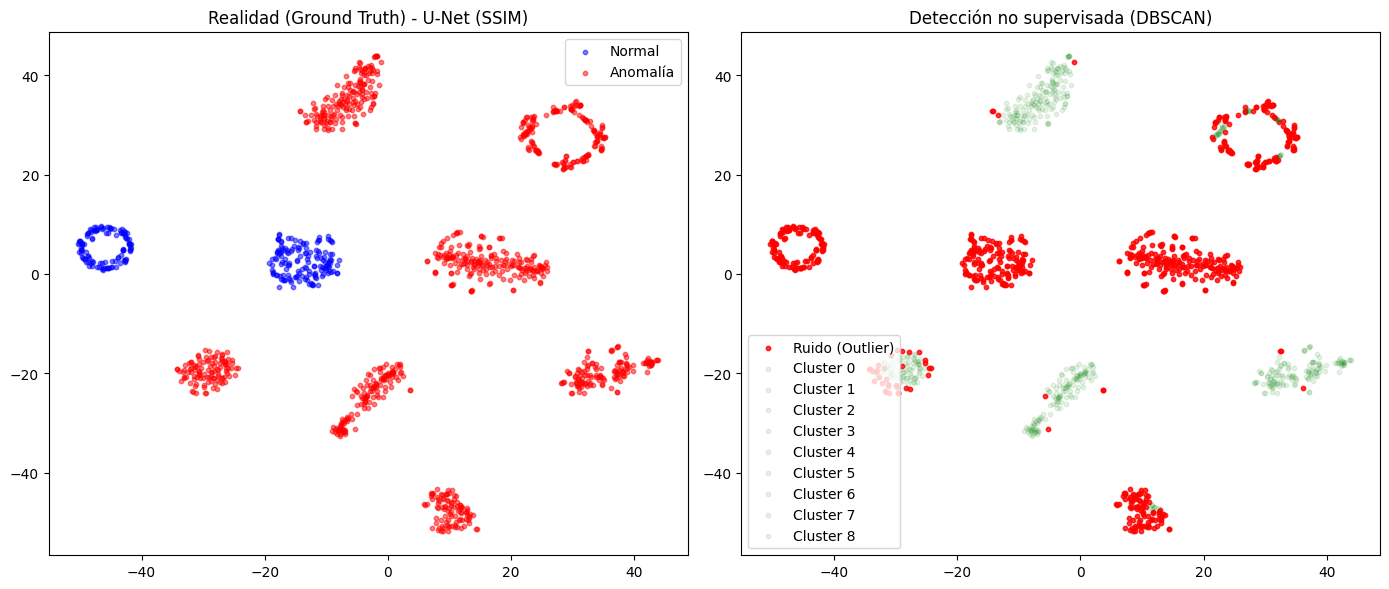

In [21]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

print(f"--- ANÁLISIS DBSCAN PARA {best_name} ---")

# 1. Reducción con PCA (Seguro para RAM)
pca = PCA(n_components=50) # Reducir a 50 dimensiones primero
pca_emb = pca.fit_transform(best_embeddings)

# 2. t-SNE para visualizar (solo 2D)
# Tomamos una muestra aleatoria si hay demasiados datos
if len(pca_emb) > 3000:
    idx = np.random.choice(len(pca_emb), 3000, replace=False)
    pca_emb_vis = pca_emb[idx]
    labels_vis = best_labels[idx]
else:
    pca_emb_vis = pca_emb
    labels_vis = best_labels

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_emb = tsne.fit_transform(pca_emb_vis)

# 3. DBSCAN
# eps es la distancia máxima entre puntos para ser del mismo cluster. 
# min_samples es cuántos puntos forman un cluster denso.
dbscan = DBSCAN(eps=5.0, min_samples=5) 
clusters = dbscan.fit_predict(pca_emb_vis)

# 4. Visualización Comparativa
plt.figure(figsize=(14, 6))

# Realidad
plt.subplot(1, 2, 1)
plt.scatter(tsne_emb[labels_vis==0, 0], tsne_emb[labels_vis==0, 1], c='blue', alpha=0.5, label='Normal', s=10)
plt.scatter(tsne_emb[labels_vis==1, 0], tsne_emb[labels_vis==1, 1], c='red', alpha=0.5, label='Anomalía', s=10)
plt.title(f"Realidad (Ground Truth) - {best_name}")
plt.legend()

# DBSCAN (-1 son outliers detectados)
plt.subplot(1, 2, 2)
unique_clusters = np.unique(clusters)
for c in unique_clusters:
    if c == -1:
        color = 'red' # Outlier para DBSCAN
        label = 'Ruido (Outlier)'
        alpha = 0.8
    else:
        color = 'green' # Cluster normal
        label = f'Cluster {c}'
        alpha = 0.1
    
    plt.scatter(tsne_emb[clusters==c, 0], tsne_emb[clusters==c, 1], c=color, alpha=alpha, label=label, s=10)

plt.title("Detección no supervisada (DBSCAN)")
plt.legend()
plt.tight_layout()
plt.show()

### VI. Análisis de Outliers mediante DBSCAN y t-SNE

Se visualizó la topología del espacio latente utilizando t-SNE (reducción a 2D) y se aplicó el algoritmo de clustering DBSCAN para identificar densidades.

**Análisis Visual (Ver Figura):**
* **Separabilidad (Gráfica Izquierda - Ground Truth):** Contrario a lo que indicaba la métrica ROC-AUC, la visualización t-SNE revela que el modelo **U-Net (SSIM)** sí ha logrado generar representaciones latentes distintas para los datos normales (puntos azules) y anómalos (puntos rojos). Se observan clústeres bien definidos y separados espacialmente.
* **Falla de la Suposición de Densidad (Gráfica Derecha - DBSCAN):** El algoritmo DBSCAN identificó la mayoría de las anomalías como parte de "clústeres válidos" (puntos verdes) en lugar de ruido (puntos rojos). Solo una fracción marginal fue etiquetada como outlier.

**Conclusión del Experimento:**
Este resultado visual explica el bajo rendimiento numérico. Las anomalías en este dataset no se manifiestan como "puntos dispersos de baja densidad" (ruido), sino que forman **sus propias regiones de alta densidad** en el espacio latente. Esto invalida la hipótesis de que DBSCAN puede detectar estas anomalías basándose puramente en densidad sin supervisión; el algoritmo interpreta los defectos recurrentes como una nueva clase "normal".